<a href="https://colab.research.google.com/github/cerezamo/NLP_project_MHMP/blob/master/NLP_project_MHMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Are men and women politician speaking the same language ? 

This projects aims at building a gender classifier for text from a corpus of French political speeches 

We use for that purpose a NLP toolbox and we proceed in three different steps. 


1.   Explore the corpus and extract relevant features
2.   Create a baseline model
3.   Compare the baseline model with a CamemBERT 



## Part I : Corpus analysis

Downloading and unzip large dataset

In [6]:
!wget -c https://github.com/cerezamo/NLP_project_MHMP/blob/master/to_put_in_colab/df_medium_deseq_var_5000.zip?raw=true -O df_medium_deseq_var_5000.zip
!wget -c https://github.com/cerezamo/NLP_project_MHMP/blob/master/to_put_in_colab/df_medium_eq_var_5000.zip?raw=true -O df_medium_eq_var_5000.zip

--2020-04-12 08:48:49--  https://github.com/cerezamo/NLP_project_MHMP/blob/master/to_put_in_colab/df_medium_deseq_var_5000.zip?raw=true
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cerezamo/NLP_project_MHMP/raw/master/to_put_in_colab/df_medium_deseq_var_5000.zip [following]
--2020-04-12 08:48:49--  https://github.com/cerezamo/NLP_project_MHMP/raw/master/to_put_in_colab/df_medium_deseq_var_5000.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cerezamo/NLP_project_MHMP/master/to_put_in_colab/df_medium_deseq_var_5000.zip [following]
--2020-04-12 08:48:49--  https://raw.githubusercontent.com/cerezamo/NLP_project_MHMP/master/to_put_in_colab/df_medium_deseq_var_5000.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.

Unzip it

In [7]:
!unzip df_medium_deseq_var_5000.zip
!unzip df_medium_eq_var_5000.zip

Archive:  df_medium_deseq_var_5000.zip
replace df_medium_deseq_var_5000.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: df_medium_deseq_var_5000.csv  
Archive:  df_medium_eq_var_5000.zip
replace df_medium_eq_var_5000.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: df_medium_eq_var_5000.csv  


### Downloading packages

In [11]:
!python -m spacy download fr_core_news_md
import nltk
nltk.download('punkt')

✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
!wget https://raw.githubusercontent.com/cerezamo/NLP_project_MHMP/master/to_put_in_colab/funct.py

--2020-04-12 08:50:19--  https://raw.githubusercontent.com/cerezamo/NLP_project_MHMP/master/to_put_in_colab/funct.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20364 (20K) [text/plain]
Saving to: ‘funct.py.1’

funct.py.1          100%[===================>]  19.89K  --.-KB/s    in 0.004s  

2020-04-12 08:50:19 (4.96 MB/s) - ‘funct.py.1’ saved [20364/20364]



In [0]:
import os, warnings
warnings.simplefilter("ignore") 
os.environ["PYTHONWARNINGS"] = "ignore" 
warnings.filterwarnings("ignore")

In [15]:
import spacy
from funct import *
import nltk
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from operator import add
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.tokenizer import Tokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import RegexpTokenizer
from os import path
from PIL import Image
import funct
sent_detector = nltk.data.load('tokenizers/punkt/french.pickle')
nlp = spacy.load('fr_core_news_md') 
import multiprocessing as mp
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tqdm import tqdm
from sklearn import utils
from sklearn.metrics import (
    recall_score,
    accuracy_score,
    precision_score,
    roc_auc_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    scorer)

IndentationError: ignored

We import our corpus in the notebook. 
This corpus has been scrapped from : https://www.vie-publique.fr/discours.
Because of the very large size of the corpus, we decide to only use 'déclarations' and 'discours' (interviews are deleted). 

In this part, we are using first our full dataset to make some basics statistical analysis then because our functions take to many time to compute we are forced to calculate it on smaller dataset. 

That's why we decide to select two subdataframe from this large one. Both have a shape of 5000 documents but one respect the repartition of male/female of our full corpus and the other is a balanced dataset with 2500/2500.


In this part we will first do some analyse (on the full dataset for the variable we already have and then on a sample dataset which respect the proportion of gender) and  then extract features (on both small dataset) which seems to be important to discriminize women and men (based on literature borrowed from psychology and language analysis).


Full df can't be read and store in Github because of it size. Feel free to contact us if you want the full dataframe.

In [0]:
df = pd.read_csv('fullDF.csv')
df.head()

,Unnamed: 0,Id,Titre,Type,Theme,Prenom,Nom,Fonction,Date,Tags,Texte,Lien,sexe
0,13,273623,"Déclaration de M. Franck Riester, ministre de ...",déclaration,Société,Franck,Riester,Ministre de la culture,2020-02-26T12:00:00Z,"Culture - Médias,Média","Merci monsieur le président, cher Bruno Studer...",https://www.vie-publique.fr/discours/273623-fr...,1.0
1,17,273677,"Déclaration de Mme Amélie de Montchalin, secré...",déclaration,International,Amélie,de Montchalin,Secrétaire d'État aux affaires européennes,2020-02-26T12:00:00Z,"Union européenne,Politique agricole commune","Merci Monsieur le Président, Monsieur le Séna...",https://www.vie-publique.fr/discours/273677-am...,2.0
2,18,273741,"Déclaration de M. Edouard Philippe, Premier mi...",déclaration,Société,Edouard,Philippe,Premier ministre,2020-02-27T12:00:00Z,"Santé - Protection sociale,Santé publique,Maladie","Avec Olivier Veran, le ministre des Solidarité...",https://www.vie-publique.fr/discours/273741-ed...,1.0
3,19,273742,"Déclaration de M. Edouard Philippe, Premier mi...",déclaration,Société,Edouard,Philippe,Premier ministre,2020-02-27T12:00:00Z,"Education - Recherche,Politique de la recherche",Monsieur le directeur général de l'Institut Pa...,https://www.vie-publique.fr/discours/273742-ed...,1.0
4,20,273663,"Déclaration de M. Christophe Castaner, ministr...",déclaration,Société,Christophe,Castaner,Ministre de l'intérieur,2020-02-26T12:00:00Z,"Société - Population,Politique de l'immigration","Monsieur le Sénateur, Permettez-moi, avant d'...",https://www.vie-publique.fr/discours/273663-ch...,1.0


### Some basic external statistics

We clean the encoding of the text as a first treatment. 

In [0]:
df.Texte = df.Texte.apply(lambda x : x.replace('\xa0','').replace('\x85','').replace('\x96','').replace('\x92',"'").replace('\x80',''))
df.Texte = df.Texte.apply(remove_source)

In [0]:
print('On average, text length is {}'.format(round(df.Texte.apply(len).mean())))

On average, text length is 11799


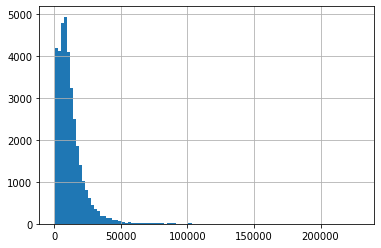

In [0]:
%matplotlib inline
df.Texte.apply(len).hist(bins=100)
plt.show()

#### Speakers gender proportions

In [0]:
print('The corpus gathers {} political speeches' .format(len(df)))
print('There are {} male speakers and {} female speakers'.format(df.sexe.map(str).value_counts()[0],df.sexe.map(str).value_counts()[1]))

The corpus gathers 35972 political speeches
There are 27059 male speakers and 8913 female speakers


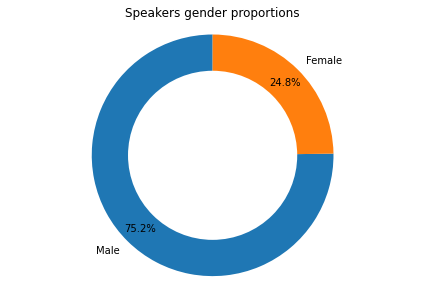

In [0]:
labels = ['Male','Female']
#colors = ['#ffcc99','#ff9999']
sizes = [ len(df[df.sexe ==1]),len(df[df.sexe ==2])]
fig, ax1 = plt.subplots()
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')  
plt.tight_layout()
plt.title("Speakers gender proportions")
plt.show()

Without surprise we have an unbalanced corpus with men being much more represented than women.

#### Speakers gender through time 

Let's see how the proportion of women and men in the corpus changed through years. 

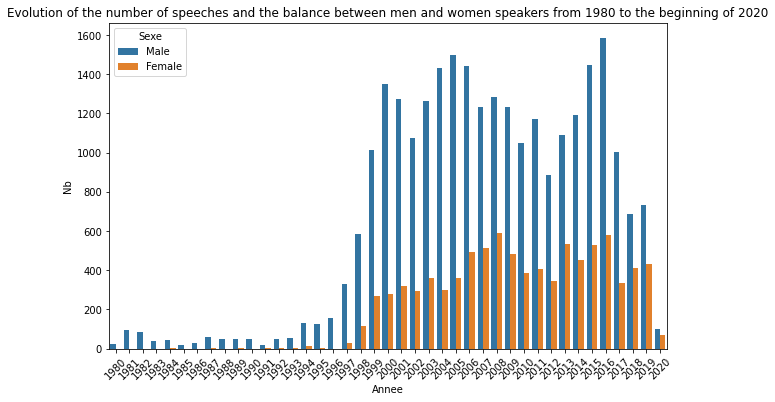

In [0]:
df['Annee']= df.Date.map(str).apply(lambda x:x[:4])
lst=[]
for an in df.Annee.unique():
    for s in df.sexe.unique():
        if s == 1:
            sexe= 'Male'
        else:
            sexe='Female'
        lst+=[(an,len(df[(df.Annee == an) & (df.sexe == s)]),sexe)]
data = pd.DataFrame(lst,columns=['Annee','Nb','Sexe'])
data=data[data['Annee']>='1980']
plt.figure(figsize=(10,6))
sns.barplot(data = data,
            x='Annee',
            y='Nb',
           hue='Sexe')
plt.xticks(rotation = 45)
plt.title("Evolution of the number of speeches and the balance between men and women speakers from 1980 to the beginning of 2020")
plt.show()

We definitely see an increase in the absolute number of female speakers. However the gap is still important. 
In the last three years we see that eventually the number of male and female speakers are really becoming closer. 

####  Speaker's gender and speeches general theme

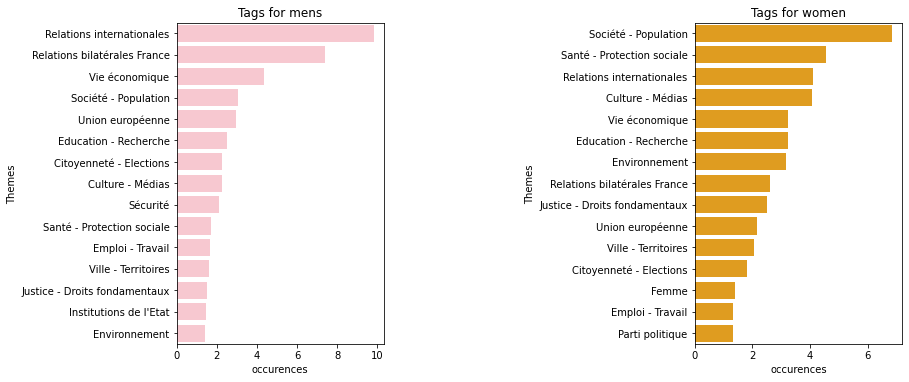

In [0]:
df.Tags.fillna('',inplace=True)
arr =df[df.sexe == 2].Tags.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_f = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_f.columns=['Themes', 'occurences']
d_f.occurences = d_f.occurences.apply(lambda x:(x/d_f.occurences.sum())*100)
d_f['sexe'] = 'Female'
arr =df[df.sexe == 1].Tags.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_m = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_m.columns=['Themes', 'occurences']
d_m.occurences = d_m.occurences.apply(lambda x:(x/d_m.occurences.sum())*100)
d_m['sexe'] = 'Male'
d = pd.concat([d_f,d_m])
plt.figure(figsize=(13,13))
plt.subplot(221)
sns.barplot(data = d[(d.occurences >= 0.5) & (d.Themes.apply(len) >0) & (d.sexe == 'Male')].sort_values('occurences',ascending=False).head(15),
            y='Themes',
            x='occurences',
           color='pink')
plt.title("Tags for mens")
plt.subplot(222)
sns.barplot(data = d[(d.occurences >= 0.6) & (d.Themes.apply(len) >0) & (d.sexe == 'Female')].sort_values('occurences',ascending=False).head(15),
            y='Themes',
            x='occurences',
           color = 'orange')
plt.title("Tags for women")
plt.subplots_adjust(wspace = 1.5)

Men and women are not talking about the same subjects. If women are more likely to speak about Society and Health, men are more likely to speak about international relations and economics. 

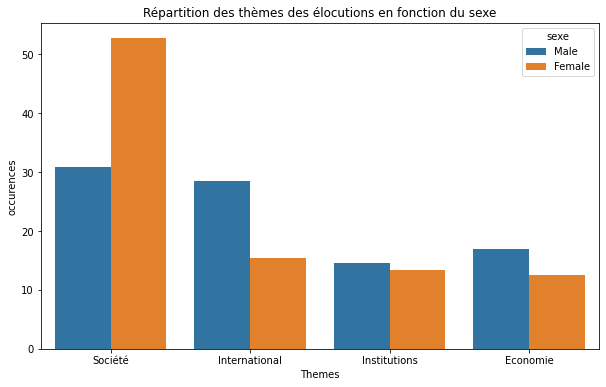

In [0]:
df.Theme.fillna('',inplace=True)
arr =df[df.sexe == 1].Theme.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_m = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_m.columns=['Themes', 'occurences']
d_m.occurences = d_m.occurences.apply(lambda x:(x/d_m.occurences.sum())*100)
d_m['sexe'] = 'Male'
arr =df[df.sexe == 2].Theme.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_f = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_f.columns=['Themes', 'occurences']
d_f.occurences = d_f.occurences.apply(lambda x:(x/d_f.occurences.sum())*100)
d_f['sexe'] = 'Female'
d = pd.concat([d_m,d_f])
plt.figure(figsize=(10,6))
sns.barplot(data = d[d.Themes != ''],hue = 'sexe',x='Themes',y='occurences')
plt.title('Répartition des thèmes des élocutions en fonction du sexe')
plt.xticks(rotation=0)
plt.show()

We represent the same chart but with a lower level of granularity in themes. The same conclustion can be drawn. And we clearly see that women are mostly speaking about society topics.

After this brief introduction we will dive into our texts. The next section focuses on cleaning and preprocessing our texts. We will try to construct some quantitative metrics that could be , in our opinion, explanatory features to differenciate female and male speakers. 


### Word-level preprocessing

Let's try different tokenizers ! 

We will now word on the reduced dataset. We will here present the result of the statistical analysis for the umbalanced dataset.

Choose one to compute (take hours for some function).

In [0]:
tokenizer = Tokenizer(nlp.vocab)
toknizer = RegexpTokenizer(r'''\w'|\w+|[^\w\s]''')

Choose one of the dataframe to compute variables creation. (uncomment one)

In [0]:
#MINIMAL DF BALANCED (500)
#df = pd.read_csv('https://raw.githubusercontent.com/cerezamo/NLP_project_MHMP/master/to_put_in_colab/minimal_df_eq.csv')
#OR MINIMAL DF UMBALANCED (500)
#df = pd.read_csv('https://raw.githubusercontent.com/cerezamo/NLP_project_MHMP/master/to_put_in_colab/minimal_df_deseq.csv')
#OR MEDIUM DF BALANCED(5000)
#df = pd.read_csv('https://raw.githubusercontent.com/cerezamo/NLP_project_MHMP/master/to_put_in_colab/medium_df_eq.csv')
#OR MEDIUM DF UMBALANCED (5000)
df = pd.read_csv('https://raw.githubusercontent.com/cerezamo/NLP_project_MHMP/master/to_put_in_colab/medium_df_deseq.csv')

In [0]:
print(len([w for w in tokenizer(df.Texte[0])]))

1702


In [0]:
([w for w in tokenizer(df.Texte[0])])[0:10]

[Messieurs,Je, suis, heureux, de, vous, saluer., Quand, je, dis, que]

In [0]:
print(len(word_tokenize(df.Texte[0], language='french')))

1932


In [0]:
word_tokenize(df.Texte[0], language='french')[0:10]

['Messieurs',
 ',',
 'Je',
 'suis',
 'heureux',
 'de',
 'vous',
 'saluer',
 '.',
 'Quand']

In [0]:
print(len(toknizer.tokenize(df.Texte[0])))

2135


In [0]:
toknizer.tokenize(df.Texte[0])[0:10]

['Messieurs',
 ',',
 'Je',
 'suis',
 'heureux',
 'de',
 'vous',
 'saluer',
 '.',
 'Quand']

In [0]:
toknizer.tokenize(df.Texte[0])[0:10]

['Messieurs',
 ',',
 'Je',
 'suis',
 'heureux',
 'de',
 'vous',
 'saluer',
 '.',
 'Quand']

The NLTK tokenizer tokenizes punctuation whereas the spacy one does not. We decide to switch to the NLTK tokenizer.

In [0]:
print('Length of spacy stopwords list is {} and length of NLTK stopwords list is {} '.format(len(list(fr_stop)),len(stopwords.words('french'))))

Length of spacy stopwords list is 602 and length of NLTK stopwords list is 157 


In [0]:
As the NLTK sent detector is far from being optimal we tried to detect sentences with the 'sent_detector_mano' function which seems to work much better on our corpus.

We also added a way to clean the 
politeness formulation like 'Madame' or 'Monsieur' because they always occur at the beggining of our document.

In [0]:
df['NbToken'] = df.Texte.apply(lambda x : len(word_tokenize(x,language='french')))
df['Token'] = df.Texte.apply(lambda x : word_tokenize(x,language='french'))

In [0]:
lst_nom = [nom for nom in set(df.Nom+ ' ' +df.Prenom) if nom not in 'ministère'] + [nom for nom in set(df.Prenom+ ' ' +df.Nom) if nom not in 'ministère']+ [nom for nom in set(df.Prenom) if nom != 'ministère'] + [nom for nom in set(df.Nom) if nom != 'ministère']
cleanFast = lst_nom + ['Mr','M','Mme','Madame','Monsieur','monsieur','madame','mme','mr','mesdames','messieurs']

We are trying now with the help of Spacy (fr_core_news_md) to extract the POS Tagging in order to quantify the grammatical structure of our text. Unfortunately, the POS tagging extraction is **very slow**. 

In [0]:
df['NbNom'],df['NbDet'],df['NbPunct'],df['NbAdj'],df['NbAdp'],df['NbPron'],df['NbVerb'],df['NbCconj'],df['NbNum'],df['NbPropn'],df['NbAdv'],df['NbSCONJ'],df['NbAUX'],df['NbIntj']=zip(*df.Texte.apply(extractPos))
 

In [0]:
df['NbMot'] = df.Texte.apply(extraire_nb_mot)
df['PronJe']=df.apply(lambda row : Pron_Type(row.Texte,nlp),axis=1)
df['PronNous']=df.apply(lambda row : Pron_Type_Plur(row.Texte,nlp),axis=1)
df['NbPres'],df['NbPast'],df['NbFut'],df['NbImp']  = zip(*df.apply(lambda row : Verb_Tens(row.Texte,nlp),axis=1))
df['NbQuest']= df.apply(lambda row : Quest(row.Texte,nlp),axis=1)
df['NbExcl']= df.apply(lambda row  : Excl(row.Texte,nlp),axis=1)
df['NbArt']= df.Texte.apply(nbArt)
df['F_mesure'] = df.apply(lambda row: f_mesure(row.NbToken,row.NbNom,row.NbAdj,row.NbAdp,row.NbArt,row.NbPron,row.NbVerb,row.NbAdv,row.NbIntj),axis=1)
df['CleanToken'] = df.Texte.apply(cleanToken)
df['Hapaxlegomena']=df.CleanToken.apply(Hapaxlegomena)
df['Hapaxdislegomena']= df.CleanToken.apply(Hapaxdislegomena)
df['UniqueWordTx']= df.CleanToken.apply(lambda x:len(set(x))/len(x))

Now we calculating Hapaxlegomena it is the number of words which appear only once while Hapaxdislegomena is the number of words which appear twice. 

We are also calculating the F_mesure ([source](https://www.cs.uic.edu/~liub/publications/EMNLP-2010-blog-gender.pdf)) which is based on the frequency of the POS usage in a text and explores the notion of implicitness
of text and is a unitary measure of text’s relative
contextuality (implicitness), as opposed to its
formality (explicitness).

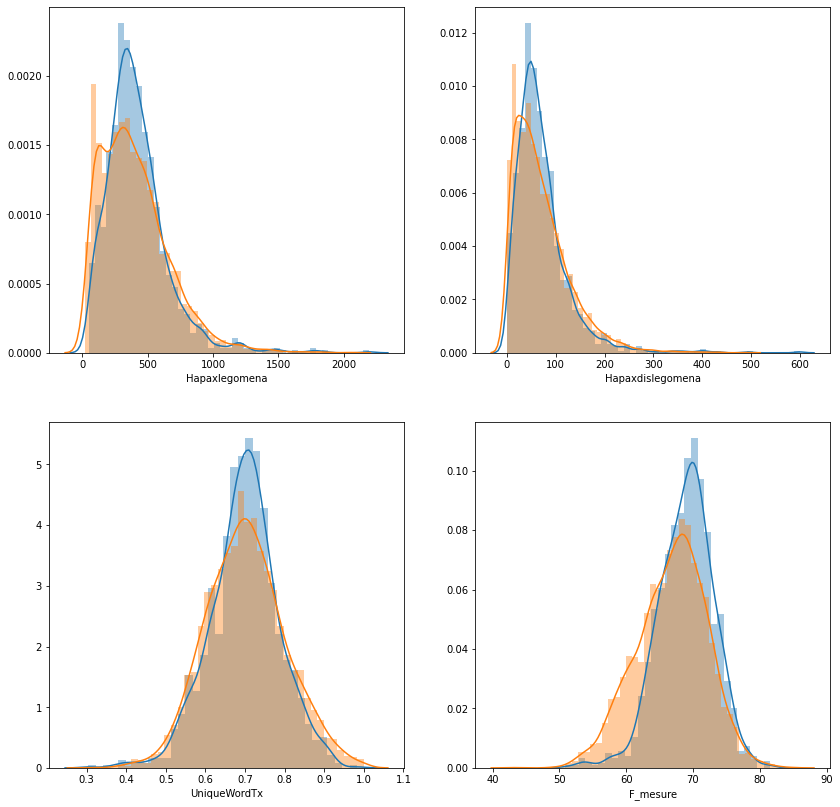

In [0]:
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
sns.distplot(df[df.sexe == 2]['Hapaxlegomena'])
sns.distplot(df[df.sexe == 1]['Hapaxlegomena'])
plt.subplot(2, 2, 2)
sns.distplot(df[df.sexe == 2]['Hapaxdislegomena'])
sns.distplot(df[df.sexe == 1]['Hapaxdislegomena'])
plt.subplot(2, 2, 3)
sns.distplot(df[df.sexe == 2]['UniqueWordTx'])
sns.distplot(df[df.sexe == 1]['UniqueWordTx'])
plt.subplot(2, 2, 4)
sns.distplot(df[df.sexe == 2]['F_mesure'])
sns.distplot(df[df.sexe == 1]['F_mesure'])
plt.show()

We can clearly see that there is a difference in the distribution of unique word. It seems that women are using more unique word than men. Moreover, we can see with the F_measure that women are more contextual than men. 

We will observe it in the different POS tagging variables.

In [0]:
df[['NbNom_prec']]=df[['NbNom']].div(df.NbMot,axis=0)
df[['NbDet_prec']]=df[['NbDet']].div(df.NbMot,axis=0)
df[['NbAdj_prec']]=df[['NbAdj']].div(df.NbMot,axis=0)
df[['NbPron_prec','NbVerb_perc','NbAUX_perc']]=df[['NbPron','NbVerb','NbAUX']].div(df.NbMot,axis=0)

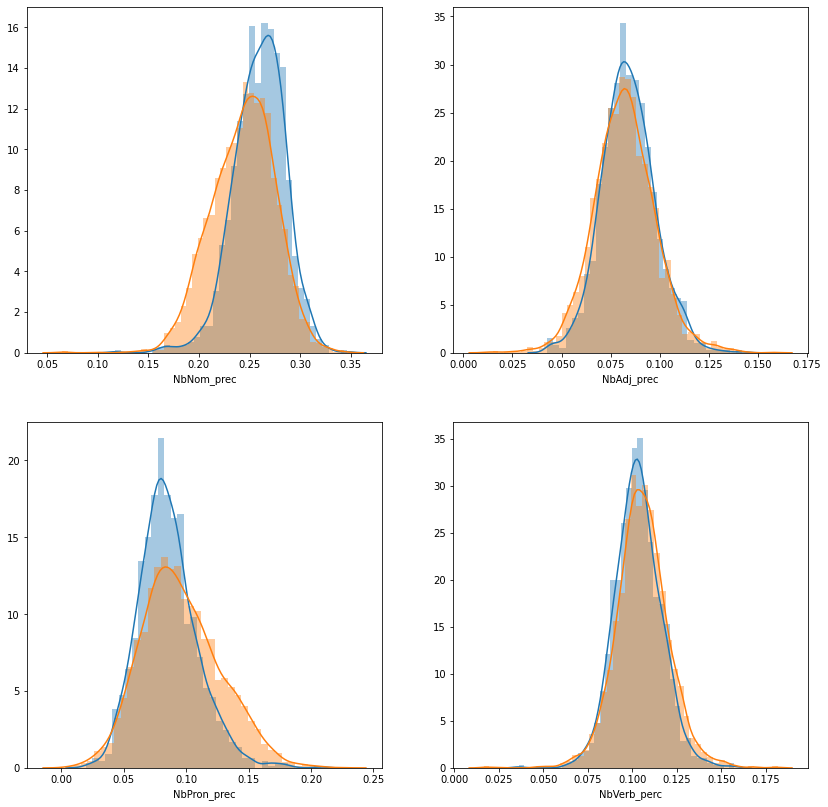

In [0]:
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
sns.distplot(df[df.sexe == 2]['NbNom_prec'])
sns.distplot(df[df.sexe == 1]['NbNom_prec'])
plt.subplot(2, 2, 2)
sns.distplot(df[df.sexe == 2]['NbAdj_prec'])
sns.distplot(df[df.sexe == 1]['NbAdj_prec'])
plt.subplot(2, 2, 3)
sns.distplot(df[df.sexe == 2]['NbPron_prec'])
sns.distplot(df[df.sexe == 1]['NbPron_prec'])
plt.subplot(2, 2, 4)
sns.distplot(df[df.sexe == 2]['NbVerb_perc'])
sns.distplot(df[df.sexe == 1]['NbVerb_perc'])
plt.show()

As we observe before, women are using more Pronoum than men while man are using more nouns.

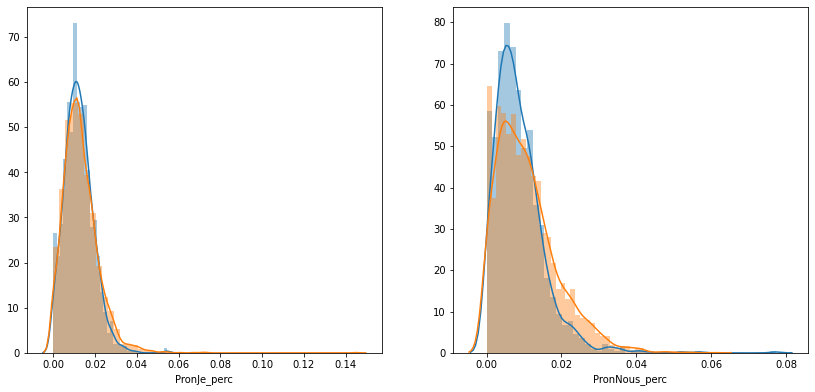

In [0]:
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
sns.distplot(df[df.sexe == 2]['PronJe_perc'])
sns.distplot(df[df.sexe == 1]['PronJe_perc'])
plt.subplot(2, 2, 2)
sns.distplot(df[df.sexe == 2]['PronNous_perc'] )
sns.distplot(df[df.sexe == 1]['PronNous_perc'])
plt.show()

However, even if past studies we saw that women tend to use more personnal pronoun like 'I', there is here no big difference. On the other hand, men are using more the first plural pronoun 'we' than women.

### Sentiment extraction using [FEEL](http://advanse.lirmm.fr/feel.php) (French Expanded Emotion Lexicon)



We are using a sentiment extraction based on a french lexicon with 14 000 distinct words expressing emotions and sentiments.

Inside this lexicon we can extract the polarity of sentiment but also six different emotions : joy, fear, sad,surprise, disgust and angry. With all of this, we calculate the frequency of each emotion.

Once again this procedure is very long and that is a reason why we only use 5000 documents in our analysis (and even with this number it takes hour to compute).

In [0]:
feel = pd.read_csv('https://raw.githubusercontent.com/cerezamo/NLP_project_MHMP/master/to_put_in_colab/FEEL.csv',sep=';')
feel.set_index('id',inplace=True)
feel.sample(10)

In [0]:
extraction_emotion(cleanTokenLemme(df.Texte[0],cleanFast))

In [0]:
check_polarity(cleanTokenLemme(df.Texte[0],cleanFast))

In [0]:
df['CleanTokensLemme'] = df.apply(lambda row : cleanTokenLemme(row.Texte,cleanFast),axis=1)
df['PolPos'],df['PolNeg'],df['PolUnk'] = zip(*df.CleanTokensLemme.apply(check_polarity))
df['FreqJoie'],df['FreqPeur'],df['FreqSad'],df['FreqColere'],df['FreqSurprise'],df['FreqDegout'] = zip(*df.CleanTokensLemme.apply(extraction_emotion))


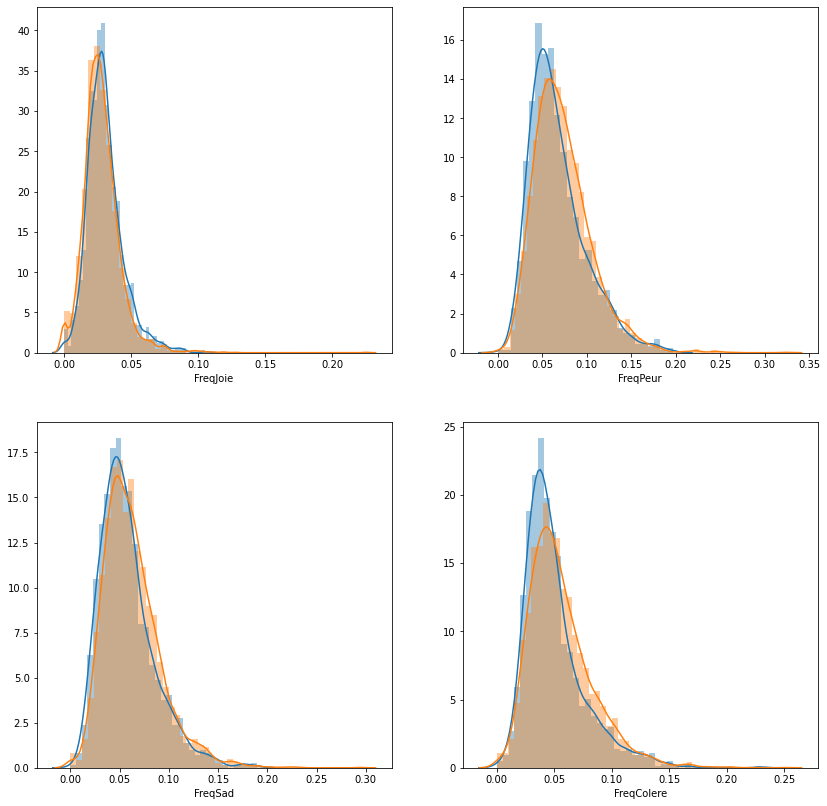

In [0]:
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
sns.distplot(df[df.sexe == 2]['FreqJoie'])
sns.distplot(df[df.sexe == 1]['FreqJoie'])
plt.subplot(2, 2, 2)
sns.distplot(df[df.sexe == 2]['FreqPeur'])
sns.distplot(df[df.sexe == 1]['FreqPeur'])
plt.subplot(2, 2, 3)
sns.distplot(df[df.sexe == 2]['FreqSad'])
sns.distplot(df[df.sexe == 1]['FreqSad'])
plt.subplot(2, 2, 4)
sns.distplot(df[df.sexe == 2]['FreqColere'])
sns.distplot(df[df.sexe == 1]['FreqColere'])
plt.show()

With the FEEL lexicon, we can observe that men are using a more angry vocabulary than women and they are also using more mad words.

### Visualize the most common word by gender

We will now draw two wordcloud, one for each sexe with our cleaned data.

In [0]:
df.CleanTokensLemme =df.CleanTokensLemme.apply(eval)

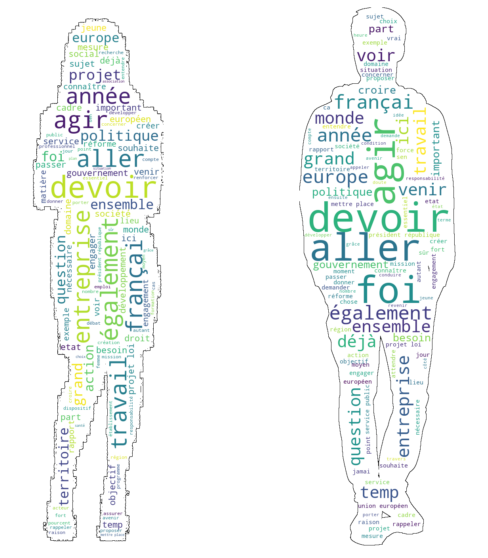

In [0]:
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
woman = np.array(Image.open("femme.png"))
wc = WordCloud(background_color="white", max_words=100, mask=woman,
               stopwords=list(fr_stop)+["c'est","d'un","d'une","qu'il","n'est","j'ai","qu'elle",'savoir','pouvoir','france','faire','pays','permettre','vouloir','falloir'], contour_width=0.5, contour_color='black')
string =''
for text in df[df.sexe == 2].CleanTokensLemme:
  string += ' '.join(text)
corpus_f = string
wc.generate(corpus_f)
man = np.array(Image.open("homme.png"))
wc2 = WordCloud(background_color="white", max_words=100, mask=man,
               stopwords=list(fr_stop)+["c'est","d'un","d'une","qu'il","n'est","j'ai","qu'elle",'savoir','pouvoir','france','faire','pays','permettre','vouloir','falloir'], contour_width=1, contour_color='black')
for text in df[df.sexe == 1].CleanTokensLemme:
  string += ' '.join(text)
corpus_m = string
wc2.generate(corpus_m)

plt.figure(figsize=[10,10])
plt.subplot(121)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.subplot(122)
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")

plt.show()

## Part II : Baseline models









In order to make some modelization we only take a substract of the data.
We select two dataframes:


1.   One with balanced labelling of women and men
2.   Another unbalanced data which respect the proportion of men/women

Both have same shapes (variable and length). 
We split our dataset in two parts : 

*   Train : 80 %
*   Test : 20 %


We try different methods. The first is using features we extracted before from each document. Then, we try other methods of word embedding which are TF-IDF,   DBOW and DMM (different approch of Doc2Vec from the gensim package). Finally, we try to combine word embeding and our extracted features.

Let's first import all the material from sklearn we need. We will use six classifier : Logistic Regression,Naive Bayes, Support Vector, Decision Tree, random Forest and XGBOOST.


In [0]:
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tqdm import tqdm
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

### Unbalanced dataset

We first work on a unbalanced dataset with 75 % of men and 25% of women (the same proportion of what we observe in the full dataframe).

In [0]:
df_deq = pd.read_csv('df_medium_deseq_var_5000.csv')

#### Feature engineering

We are just using our calculated features to predict the sexe. We will just launch our algorithm with a seed set but no other option.

In [0]:
X = df_deq[['UniqueWordTx', 'RateCleanRaw',
        'NbPunct', 'NbAdp','NbCconj', 'NbNum', 'NbPropn', 'NbAdv', 'NbSCONJ', 'NbIntj', 'NbPres', 'NbPast', 'NbFut', 'NbImp',
        'NbArt', 'F_mesure', 'NbNom_prec', 'NbDet_prec', 'NbAdj_prec','NbPron_prec', 'NbVerb_perc', 'NbAUX_perc', 'PronJe_perc','PronNous_perc', 'NbQuest_perc', 'NbExcl_perc',
       'PolPos', 'PolNeg', 'PolUnk', 'FreqJoie', 'FreqPeur', 'FreqSad','FreqColere', 'FreqSurprise', 'FreqDegout']]
y = df_deq.sexe.apply(lambda x : 1 if x == 2 else 0)


In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42 ,test_size =0.2)

In [0]:
models  = [GaussianNB(),RandomForestClassifier(random_state=42),DecisionTreeClassifier(random_state=42),
          XGBClassifier(random_state = 42),LogisticRegression(random_state = 42,max_iter=1000),SVC(random_state = 42,probability=True)]

To evaluate our model, we create a function to extract metrics. With this help we can easely extract them and make a quantitative analysis.

In [0]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train,X_test,y_train,y_test)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.720000,0.067265,0.254237,0.106383,0.501136
RFC,0.763333,0.089686,0.666667,0.158103,0.537458
DTC,0.667778,0.372197,0.342975,0.356989,0.568669
XGBOOST,0.747778,0.080717,0.450000,0.136882,0.524111
SVC_linear,0.738889,0.049327,0.323529,0.085603,0.507677
SVC_rbf,0.752222,0.000000,0.000000,0.000000,0.500000


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')
Classification report :               precision    recall  f1-score   support

           0       0.79      0.77      0.78       677
           1       0.34      0.37      0.36       223

    accuracy                           0.67       900
   macro avg       0.57      0.57      0.57       900
weighted avg       0.68      0.67      0.67       900

Accuracy :  0.6677777777777778
AUC :  0.5686688171900564


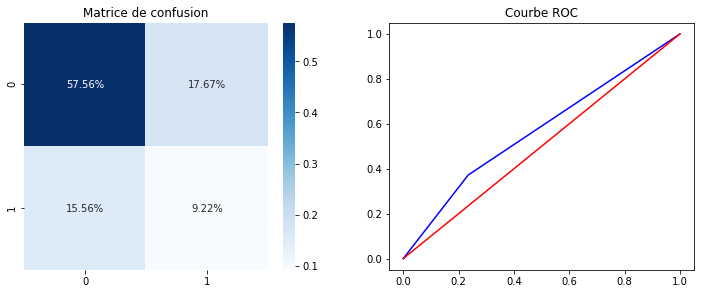

In [0]:
predictions(DecisionTreeClassifier(random_state=42),X_train,X_test,y_train,y_test)

As we can observe, we can't take the accuracy as a good metric in an unbalanced classification problem. Because 66.7 % of accuracy seems to be a good start but when you look deeper in the result with a classification report or a confusion matrix, you can see that the best clasifier for this feature is clearly not working well. We only got a 0.356 f1 score and most of the inputs are just classified as the majority class.

#### TF-IDF

This time, we use a TF-IDF on our text to see if there is an improvment compare to our feature extraction. After some test, we saw that if we use cleaned document it always end with lower prediction. So we choose to only use our raw text. 

In this approch we first use only unigram and then trigram.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=fr_stop)
X = tfidfconverter.fit_transform(df_deq['Texte']).toarray()
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42 ,test_size =0.2)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['qu', 'quelqu'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [0]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train,X_test,y_train,y_test)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.741111,0.663677,0.483660,0.559546,0.715147
RFC,0.788889,0.170404,0.883721,0.285714,0.581509
DTC,0.730000,0.457399,0.455357,0.456376,0.638596
XGBOOST,0.830000,0.394619,0.830189,0.534954,0.684015
RegLog,0.812222,0.349776,0.764706,0.480000,0.657163
SVC_rbf,0.810000,0.340807,0.760000,0.470588,0.652678


GaussianNB(priors=None, var_smoothing=1e-09)
Classification report :               precision    recall  f1-score   support

           0       0.87      0.77      0.82       677
           1       0.48      0.66      0.56       223

    accuracy                           0.74       900
   macro avg       0.68      0.72      0.69       900
weighted avg       0.78      0.74      0.75       900

Accuracy :  0.7411111111111112
AUC :  0.7151472799411809


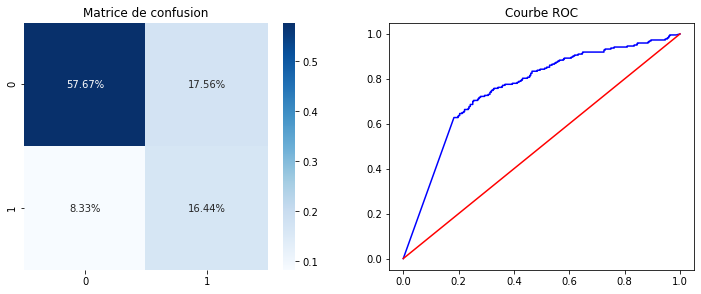

In [0]:
predictions(GaussianNB(),X_train,X_test,y_train,y_test)

In [0]:
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=fr_stop, ngram_range=(2,3))
X = tfidfconverter.fit_transform(df_deq['Texte']).toarray()
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42 ,test_size =0.2)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['qu', 'quelqu'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [0]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train,X_test,y_train,y_test)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.731111,0.704036,0.471471,0.564748,0.722033
RFC,0.785556,0.273543,0.663043,0.387302,0.613876
DTC,0.674444,0.309417,0.331731,0.320186,0.552050
XGBOOST,0.782222,0.161435,0.800000,0.268657,0.574071
RegLog,0.800000,0.278027,0.765432,0.407895,0.624981
SVC_rbf,0.796667,0.264574,0.756410,0.392027,0.618254


GaussianNB(priors=None, var_smoothing=1e-09)
Classification report :               precision    recall  f1-score   support

           0       0.88      0.74      0.81       677
           1       0.47      0.70      0.56       223

    accuracy                           0.73       900
   macro avg       0.68      0.72      0.69       900
weighted avg       0.78      0.73      0.75       900

Accuracy :  0.7311111111111112
AUC :  0.7220327082684754


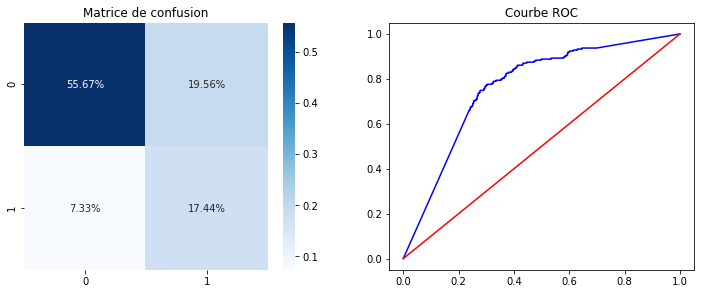

In [0]:
predictions(GaussianNB(),X_train,X_test,y_train,y_test)

The best classifier is a Naive Bayes with unigram as TF-IDF. We achieve an AUC of 0.72 and if we take a look at our confusion matrix we can see that most of the women of the corpus are correctly classified but there are too much men who are classified as women. We are improving our f1 score of more than 0.2 points. 

#### Word embeddings (TF-IDF/DBOW/DMM)

We will now use a Distributed Bag of Words (DBOW) and a Distributed Memory (DMM) with some classical initialisation parameters. 
This time we use the cleaned tokens lemme we obtain with our function.



In [0]:
train,test = train_test_split(df_deq[['CleanTokensLemme','sexe']],random_state = 42 ,test_size =0.2)
train_tagged = train.apply(lambda r: TaggedDocument(words=r.CleanTokensLemme, tags=[r.sexe]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=r.CleanTokensLemme, tags=[r.sexe]), axis=1)

In [0]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=2)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 4000/4000 [00:00<00:00, 2931030.05it/s]


In [0]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [0]:
y_train_dbow, X_train_dbow = vec_for_learning(model_dbow, train_tagged)
y_test_dbow, X_test_dbow = vec_for_learning(model_dbow, test_tagged)
y_train_dbow = pd.DataFrame(y_train_dbow,columns=['sexe']).sexe.apply(lambda x: 1 if x == 2 else 0)
y_test_dbow = pd.DataFrame(y_test_dbow,columns=['sexe']).sexe.apply(lambda x: 1 if x == 2 else 0)
X_train_dbow =  pd.DataFrame(X_train_dbow)
X_test_dbow =  pd.DataFrame(X_test_dbow)

In [0]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train_dbow,X_test_dbow,y_train_dbow,y_test_dbow)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.672222,0.192825,0.272152,0.225722,0.511479
RFC,0.748889,0.008969,0.285714,0.017391,0.500792
DTC,0.612222,0.251121,0.235294,0.242950,0.491144
XGBOOST,0.752222,0.008969,0.500000,0.017621,0.503007
SVC_linear,0.752222,0.000000,0.000000,0.000000,0.500000
SVC_rbf,0.752222,0.000000,0.000000,0.000000,0.500000


The metrics are clearly droping with this method. This is clearly not a good way to classify our problem. Moreover, we can observe that for two classifiers we got 75% accuracy. Not bad ! But this is because they always predict men whatever we feed them.

Let's now try a distrubed memory model.

In [0]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=2, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 4000/4000 [00:00<00:00, 744991.83it/s]


In [0]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

In [0]:
y_train_dmm, X_train_dmm = vec_for_learning(model_dmm, train_tagged)
y_test_dmm, X_test_dmm = vec_for_learning(model_dmm, test_tagged)
y_train_dmm = pd.DataFrame(y_train_dmm,columns=['sexe']).sexe.apply(lambda x: 1 if x == 2 else 0)
y_test_dmm = pd.DataFrame(y_test_dmm,columns=['sexe']).sexe.apply(lambda x: 1 if x == 2 else 0)
X_train_dmm =  pd.DataFrame(X_train_dmm)
X_test_dmm =  pd.DataFrame(X_test_dmm)

In [0]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train_dmm,X_test_dmm,y_train_dmm,y_test_dmm)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.650000,0.515695,0.357143,0.422018,0.604967
RFC,0.771111,0.107623,0.774194,0.188976,0.548642
DTC,0.634444,0.345291,0.296154,0.318841,0.537491
XGBOOST,0.770000,0.152466,0.653846,0.247273,0.562939
SVC_linear,0.764444,0.098655,0.666667,0.171875,0.541203
SVC_rbf,0.757778,0.035874,0.727273,0.068376,0.515722


GaussianNB(priors=None, var_smoothing=1e-09)
Classification report :               precision    recall  f1-score   support

           0       0.81      0.69      0.75       677
           1       0.36      0.52      0.42       223

    accuracy                           0.65       900
   macro avg       0.59      0.60      0.59       900
weighted avg       0.70      0.65      0.67       900

Accuracy :  0.65
AUC :  0.6049671791271171


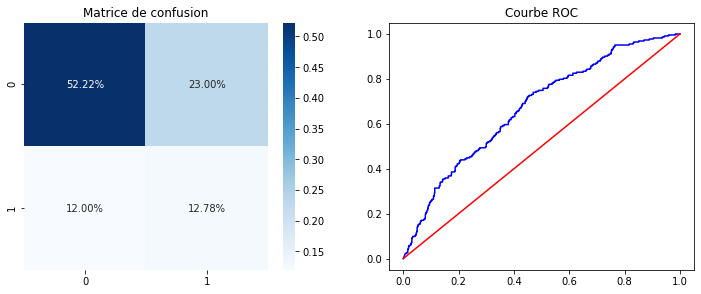

In [0]:
predictions(GaussianNB(),X_train_dmm,X_test_dmm,y_train_dmm,y_test_dmm)

The results are a little bit better but their are still under our previous try with others methods. So we will not keep them and we will proceed in the next part with the TF-IDF approach plus our features.

#### Embeddings + features

The best embedding method that we used is the TF-IDF with a f1 score of 0.56. We want to see if we can improve it when using our features.


In [0]:
X_train_idf_tri,X_test_idf_tri = pd.DataFrame(X_train),pd.DataFrame(X_test)
X = df_deq[['UniqueWordTx', 'RateCleanRaw',
        'NbPunct', 'NbAdp','NbCconj', 'NbNum', 'NbPropn', 'NbAdv', 'NbSCONJ', 'NbIntj', 'NbPres', 'NbPast', 'NbFut', 'NbImp',
        'NbArt', 'F_mesure', 'NbNom_prec', 'NbDet_prec', 'NbAdj_prec','NbPron_prec', 'NbVerb_perc', 'NbAUX_perc', 'PronJe_perc','PronNous_perc', 'NbQuest_perc', 'NbExcl_perc',
       'PolPos', 'PolNeg', 'PolUnk', 'FreqJoie', 'FreqPeur', 'FreqSad','FreqColere', 'FreqSurprise', 'FreqDegout']]

In [0]:
X_train,X_test=train_test_split(X,random_state=42,test_size=0.2)

In [0]:
idx = X_train.index
X_train_idf_tri = X_train_idf_tri.set_index(idx)
X_train_combine = pd.concat([X_train_idf_tri, X_train], axis=1)
idx=  X_test.index
X_test_idf_tri = X_test_idf_tri.set_index(idx)
X_test_combine = pd.concat([X_test_idf_tri, X_test], axis=1)

In [0]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train_combine,X_test_combine,y_train,y_test)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.740000,0.354260,0.467456,0.403061,0.610660
RFC,0.776667,0.152466,0.739130,0.252788,0.567371
DTC,0.690000,0.390135,0.378261,0.384106,0.589454
XGBOOST,0.773333,0.130045,0.743590,0.221374,0.557637
RegLog,0.741111,0.067265,0.375000,0.114068,0.515168
SVC_rbf,0.752222,0.000000,0.000000,0.000000,0.500000


GaussianNB(priors=None, var_smoothing=1e-09)
Classification report :               precision    recall  f1-score   support

           0       0.80      0.87      0.83       677
           1       0.47      0.35      0.40       223

    accuracy                           0.74       900
   macro avg       0.64      0.61      0.62       900
weighted avg       0.72      0.74      0.73       900

Accuracy :  0.74
AUC :  0.6106603254929754


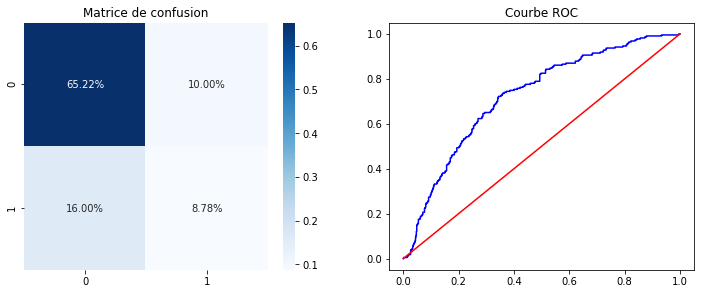

In [0]:
predictions(GaussianNB(),X_train_combine,X_test_combine,y_train,y_test)

Unfortunately, when we combine both method we are not getting any improvement on the unbalanced dataset. 

#### Conclusion on the umbalanced dataset

As we can see, the best method seem to be the TF-Idf tri-gram with a Naive Bayes model (with 0.5647 f1_score and a AUC of 0.72).
Moreover with the confusion matrix we find that the model is almost classying all women correctly.
We will now try the same approch with a balanced dataset and after that we will try to tune the best model to extract some gender marker.



### Balanced dataset

When working with unbalanced labels you have several choice to balance them in order to train models in more efficient way. We choose to down-sample the majority class in order to have 2500 documents for each gender. 

We are just doing the same previous operations but with our balanced dataset.

After that we will choose the best model, fine tune it and then try to extract some feature importance.
We will not explain anything except our best result in this part because it is same processing as previously presented


In [0]:
df_eq = pd.read_csv('df_medium_eq_var_5000.csv')

#### Feature engineering

In [0]:
X = df_eq[['UniqueWordTx', 'RateCleanRaw',
        'NbPunct', 'NbAdp','NbCconj', 'NbNum', 'NbPropn', 'NbAdv', 'NbSCONJ', 'NbIntj', 'NbPres', 'NbPast', 'NbFut', 'NbImp',
        'NbArt', 'F_mesure', 'NbNom_prec', 'NbDet_prec', 'NbAdj_prec','NbPron_prec', 'NbVerb_perc', 'NbAUX_perc', 'PronJe_perc','PronNous_perc', 'NbQuest_perc', 'NbExcl_perc',
       'PolPos', 'PolNeg', 'PolUnk', 'FreqJoie', 'FreqPeur', 'FreqSad','FreqColere', 'FreqSurprise', 'FreqDegout']]
y = df_eq.sexe.apply(lambda x : 1 if x == 2 else 0)


In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42 ,test_size =0.2)

In [0]:
models  = [GaussianNB(),RandomForestClassifier(random_state=42),DecisionTreeClassifier(random_state=42),
          XGBClassifier(random_state = 42),LogisticRegression(random_state = 42,max_iter=1000),SVC(random_state = 42,probability=True)]
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train,X_test,y_train,y_test)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.519,0.884,0.510983,0.647619,0.519
RFC,0.652,0.714,0.635231,0.672316,0.652
DTC,0.572,0.574,0.571713,0.572854,0.572
XGBOOST,0.653,0.748,0.628571,0.683105,0.653
RegLog,0.632,0.658,0.625475,0.641326,0.632
SVC_rbf,0.567,0.696,0.553259,0.616475,0.567


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Classification report :               precision    recall  f1-score   support

           0       0.69      0.56      0.62       500
           1       0.63      0.75      0.68       500

    accuracy                           0.65      1000
   macro avg       0.66      0.65      0.65      1000
weighted avg       0.66      0.65      0.65      1000

Accuracy :  0.653
AUC :  0.653


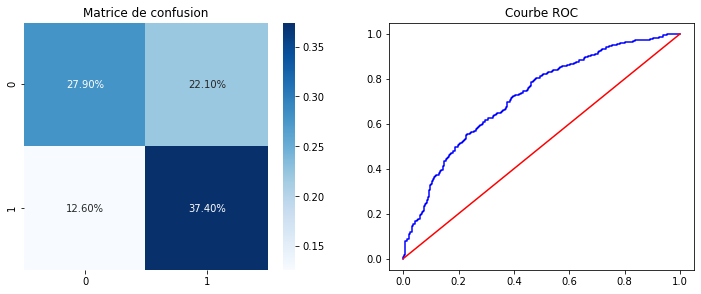

In [0]:
predictions(XGBClassifier(random_state = 42),X_train,X_test,y_train,y_test)

Our best model for our features is now a XGBOOST. The confusion matrix show that most of the women are correctly classified but too many men are classified as women. For the balanced dataset, we have a 0.68 f1 score to bit

#### Word embeddings (TF-IDF/DBOW/DMM)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=fr_stop)
X = tfidfconverter.fit_transform(df_eq['Texte']).toarray()
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42 ,test_size =0.2)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['qu', 'quelqu'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [0]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train,X_test,y_train,y_test)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.717,0.700,0.724638,0.712106,0.717
RFC,0.765,0.754,0.770961,0.762386,0.765
DTC,0.673,0.688,0.667961,0.677833,0.673
XGBOOST,0.765,0.766,0.764471,0.765235,0.765
RegLog,0.769,0.766,0.770624,0.768305,0.769
SVC_rbf,0.768,0.778,0.762745,0.770297,0.768


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)
Classification report :               precision    recall  f1-score   support

           0       0.77      0.76      0.77       500
           1       0.76      0.78      0.77       500

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.77      1000
weighted avg       0.77      0.77      0.77      1000

Accuracy :  0.768
AUC :  0.768


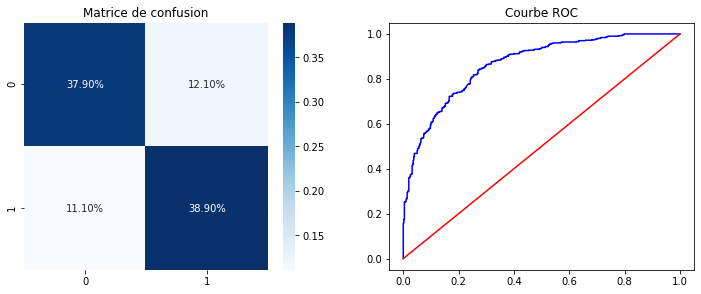

In [0]:
predictions(SVC(random_state = 42,probability=True),X_train,X_test,y_train,y_test)

In [0]:
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=fr_stop, ngram_range=(2,3))
X = tfidfconverter.fit_transform(df_eq['Texte']).toarray()
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42 ,test_size =0.2)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['qu', 'quelqu'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [0]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train,X_test,y_train,y_test)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.721,0.668,0.747204,0.705385,0.721
RFC,0.713,0.704,0.716904,0.710394,0.713
DTC,0.639,0.652,0.635478,0.643633,0.639
XGBOOST,0.706,0.658,0.727876,0.691176,0.706
RegLog,0.739,0.736,0.740443,0.738215,0.739
SVC_rbf,0.739,0.740,0.738523,0.739261,0.739


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)
Classification report :               precision    recall  f1-score   support

           0       0.74      0.74      0.74       500
           1       0.74      0.74      0.74       500

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000

Accuracy :  0.739
AUC :  0.739


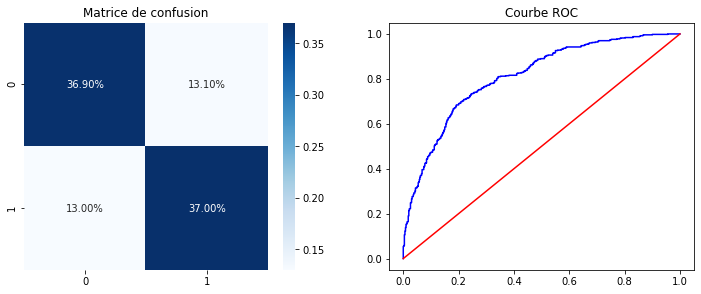

In [0]:
predictions(SVC(random_state = 42,probability=True),X_train,X_test,y_train,y_test)

In [0]:
train,test = train_test_split(df_eq[['CleanTokensLemme','sexe']],random_state = 42 ,test_size =0.2)
train_tagged = train.apply(lambda r: TaggedDocument(words=r.CleanTokensLemme, tags=[r.sexe]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=r.CleanTokensLemme, tags=[r.sexe]), axis=1)
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=2)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [0]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors
y_train_dbow, X_train_dbow = vec_for_learning(model_dbow, train_tagged)
y_test_dbow, X_test_dbow = vec_for_learning(model_dbow, test_tagged)
y_train_dbow = pd.DataFrame(y_train_dbow,columns=['sexe']).sexe.apply(lambda x: 1 if x == 2 else 0)
y_test_dbow = pd.DataFrame(y_test_dbow,columns=['sexe']).sexe.apply(lambda x: 1 if x == 2 else 0)
X_train_dbow =  pd.DataFrame(X_train_dbow)
X_test_dbow =  pd.DataFrame(X_test_dbow)

In [0]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train_dbow,X_test_dbow,y_train_dbow,y_test_dbow)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.483,0.262,0.469534,0.336329,0.483
RFC,0.516,0.456,0.518182,0.485106,0.516
DTC,0.483,0.490,0.483235,0.486594,0.483
XGBOOST,0.501,0.488,0.501027,0.494428,0.501
RegLog,0.486,0.516,0.486792,0.500971,0.486
SVC_rbf,0.482,0.662,0.486765,0.561017,0.482


In [0]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=2, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

In [0]:
y_train_dmm, X_train_dmm = vec_for_learning(model_dmm, train_tagged)
y_test_dmm, X_test_dmm = vec_for_learning(model_dmm, test_tagged)
y_train_dmm = pd.DataFrame(y_train_dmm,columns=['sexe']).sexe.apply(lambda x: 1 if x == 2 else 0)
y_test_dmm = pd.DataFrame(y_test_dmm,columns=['sexe']).sexe.apply(lambda x: 1 if x == 2 else 0)

X_train_dmm =  pd.DataFrame(X_train_dmm)
X_test_dmm =  pd.DataFrame(X_test_dmm)

In [0]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train_dmm,X_test_dmm,y_train_dmm,y_test_dmm)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.600,0.502,0.624378,0.556541,0.600
RFC,0.655,0.620,0.666667,0.642487,0.655
DTC,0.561,0.572,0.559687,0.565776,0.561
XGBOOST,0.645,0.612,0.655246,0.632885,0.645
RegLog,0.644,0.604,0.656522,0.629167,0.644
SVC_rbf,0.668,0.616,0.687500,0.649789,0.668


The best embedding method is once again the TF-IDF with now a SVC. We got a improvment of 0.03 points in our f1 score.

#### Embeddings + features

In [0]:
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=fr_stop)
X = tfidfconverter.fit_transform(df_eq['Texte']).toarray()
X_train_idf,X_test_idf,y_train_idf,y_test_idf = train_test_split(X,y,random_state = 42 ,test_size =0.2)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['qu', 'quelqu'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [0]:
X_train_idf,X_test_idf = pd.DataFrame(X_train_idf),pd.DataFrame(X_test_idf)
X = df_eq[['NbToken', 'NbSyllables', 'NbMot', 'NbPhrases','NbCleanToken', 'NbPonct', 'NbSw','Hapaxlegomena', 'Hapaxdislegomena', 'UniqueWordTx', 'RateCleanRaw',
       'NbNom', 'NbDet', 'NbPunct', 'NbAdj', 'NbAdp', 'NbPron', 'NbVerb','NbCconj', 'NbNum', 'NbPropn', 'NbAdv', 'NbSCONJ', 'NbAUX', 'NbIntj','PronJe', 'PronNous', 'NbPres', 'NbPast', 'NbFut', 'NbImp', 'NbQuest',
       'NbExcl', 'NbArt', 'F_mesure', 'NbNom_prec', 'NbDet_prec', 'NbAdj_prec','NbPron_prec', 'NbVerb_perc', 'NbAUX_perc', 'PronJe_perc','PronNous_perc', 'NbQuest_perc', 'NbExcl_perc',
       'PolPos', 'PolNeg', 'PolUnk', 'FreqJoie', 'FreqPeur', 'FreqSad','FreqColere', 'FreqSurprise', 'FreqDegout']]
X_train,X_test=train_test_split(X,random_state=42,test_size=0.2)

In [0]:
idx = X_train.index
X_train_idf = X_train_idf.set_index(idx)
X_train_combine = pd.concat([X_train_idf, X_train], axis=1)
idx=  X_test.index
X_test_idf = X_test_idf.set_index(idx)
X_test_combine = pd.concat([X_test_idf, X_test], axis=1)

In [0]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train_combine,X_test_combine,y_train,y_test)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.560,0.900,0.535714,0.671642,0.560
RFC,0.771,0.758,0.778234,0.767984,0.771
DTC,0.681,0.704,0.673040,0.688172,0.681
XGBOOST,0.764,0.790,0.750951,0.769981,0.764
RegLog,0.639,0.670,0.630885,0.649855,0.639
SVC_rbf,0.563,0.696,0.549763,0.614298,0.563


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Classification report :               precision    recall  f1-score   support

           0       0.78      0.74      0.76       500
           1       0.75      0.79      0.77       500

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000

Accuracy :  0.764
AUC :  0.764


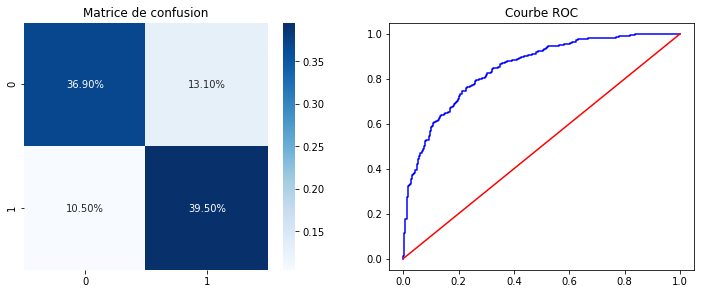

In [0]:
predictions(XGBClassifier(random_state = 42),X_train_combine,X_test_combine,y_train,y_test)

#### Conclusion on the balanced dataset

We obtain the best results when using our homemade features and a non-optimised  classical TF-IDF. We obtain a f1_score of 0.77. We increased our results by 0.2 compared to the best classifier for the unbalanced dataset. 

We will now tune the TF IDF.


### Tunning the best classifier

Our best classifier seems to be a XGBOOST with featured variables plus a TF-IDF.

We will make a classical GridSearch CV tune our TF-IDF and then run the XGBOOST on this optimal TF-IDF

#### GridSearchCV

First, we tune our TF-IDF

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [0]:
X = df_eq['Texte']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42 ,test_size =0.2)
xgb_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('xgb', XGBClassifier(random_state = 42))
])
xgb_pipe.fit(X_train, y_train)
tf_params = {
 "tvec__max_features":[100, 500,1000,1500,2000,2500,3000,3500,4000,5000],
 "tvec__ngram_range": [(1, 1), (1, 2), (2, 2),(3,3),(4,4)],
 "tvec__stop_words": [fr_stop],
 "tvec__max_df":[0.7],
 "tvec__min_df":[0.2,0.3,0.1],
 "tvec__norm":['l2']}
xgb_gs = GridSearchCV(xgb_pipe, param_grid=tf_params, cv = 5, verbose = 1, n_jobs = 1)
xgb_gs.fit(X_train, y_train)

In [0]:
xgb_gs.best_params_

After a lot of computation time, we finally come with an optimal TF-IDF with 1000 features and a range (1,2). We are now launching our classifier to observe the best results.
#### Results of the tuned classifier

In [0]:
tfidfconverter = TfidfVectorizer(max_features=1000, min_df=0.1, max_df=0.7, stop_words=fr_stop,ngram_range= (1, 2))
X = tfidfconverter.fit_transform(df_eq['Texte']).toarray()
X_train_idf,X_test_idf,y_train_idf,y_test_idf = train_test_split(X,y,random_state = 42 ,test_size =0.2)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['qu', 'quelqu'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [0]:
X_train_idf,X_test_idf = pd.DataFrame(X_train_idf),pd.DataFrame(X_test_idf)
X = df_eq[['UniqueWordTx', 'RateCleanRaw',
        'NbPunct', 'NbAdp','NbCconj', 'NbNum', 'NbPropn', 'NbAdv', 'NbSCONJ', 'NbIntj', 'NbPres', 'NbPast', 'NbFut', 'NbImp',
        'NbArt', 'F_mesure', 'NbNom_prec', 'NbDet_prec', 'NbAdj_prec','NbPron_prec', 'NbVerb_perc', 'NbAUX_perc', 'PronJe_perc','PronNous_perc', 'NbQuest_perc', 'NbExcl_perc',
       'PolPos', 'PolNeg', 'PolUnk', 'FreqJoie', 'FreqPeur', 'FreqSad','FreqColere', 'FreqSurprise', 'FreqDegout']]
X_train,X_test=train_test_split(X,random_state=42,test_size=0.2)
idx = X_train.index
X_train_idf = X_train_idf.set_index(idx)
X_train_combine = pd.concat([X_train_idf, X_train], axis=1)
idx=  X_test.index
X_test_idf = X_test_idf.set_index(idx)
X_test_combine = pd.concat([X_test_idf, X_test], axis=1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Classification report :               precision    recall  f1-score   support

           0       0.79      0.75      0.77       500
           1       0.76      0.80      0.78       500

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000

Accuracy :  0.776
AUC :  0.776


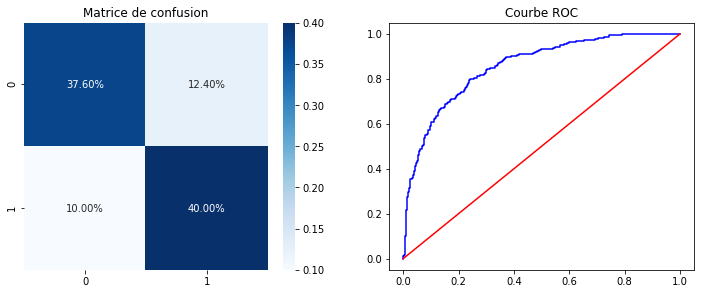

In [0]:
predictions(XGBClassifier(random_state = 42),X_train_combine,X_test_combine,y_train,y_test)

Finaly we obtain a model with an AUC of 0.776 which results in a pretty good ROC curve. Plus, we obtain now an accuracy of 77.6% which is beyond our first assumption which was a rate between 60% and 70%. 
Concerning our f1 score we are getting a final score of 0.78 which is closer than ever to 1.

Compare to our non tuned TF-IDF model we obtain a gain of 1% of accuracy. The model has just improved a bit in the classification of both class.

There is still 20% of our test set which is not correctly classified. After looking at feature importance we will try to understand briefly why they are incorrectly classified.

#### Going deeper in results

Let's make a quick qualitative analysis and try to understand what we can extract from these results. 
First, we are trying to extract the most important score on the TF-IDF for each gender. 

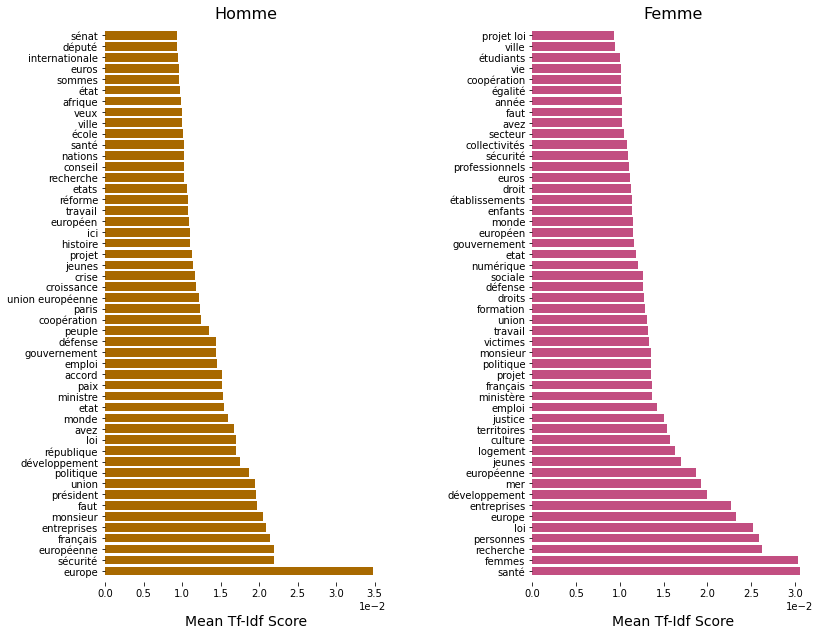

In [0]:
features=tfidfconverter.get_feature_names()
plot_tfidf_classfeats_h(top_feats_by_class(X_train_idf, y_train_idf, features, min_tfidf=0.1, top_n=50))

We observe that some words do not have the same importance. For instance, women display a high mean TF-IDF score for 'santé' when 'europe' is the highiest for men(5th in the women list). Moreover, we observe that some thematics are dividing gender. Men most important mean TF-IDF scores concern Europe, republic, economics or defence. While women most important mean TF-IDF scores are society, people, justice and familly.

This is certainly correlated with women positions at the government.

In [0]:
model = XGBClassifier(random_state = 42)
X_train_combine.columns=features+list(X.columns)
model.fit(X_train_combine,y_train_idf)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

We want now to see if our homemade features have an importance in the model. 

In [0]:
df_imp = pd.DataFrame(model.feature_importances_[1000:],columns=['Imp']).set_index(X.columns)
df_imp.sort_values('Imp',ascending=False,inplace=True)

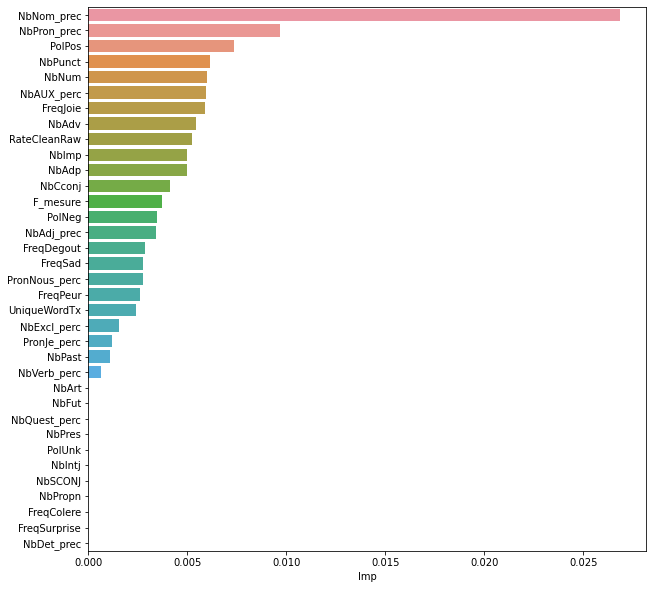

In [0]:
plt.figure(figsize=(10,10))
sns.barplot(x = df_imp.Imp,y = df_imp.index)

We can observe that some of the variables are clearly pennalized by the XGBOOST l2 penalty. For example, variables such as the number of articles or the number of questions marks are clearly not helping to dicriminize gender. On the other hand, the number of pronoum or the positive polarity of the text is helping to classify gender. We retrieve a result that has been observed in previous studies.

In [0]:
from xgboost import plot_importance

<Figure size 720x720 with 0 Axes>

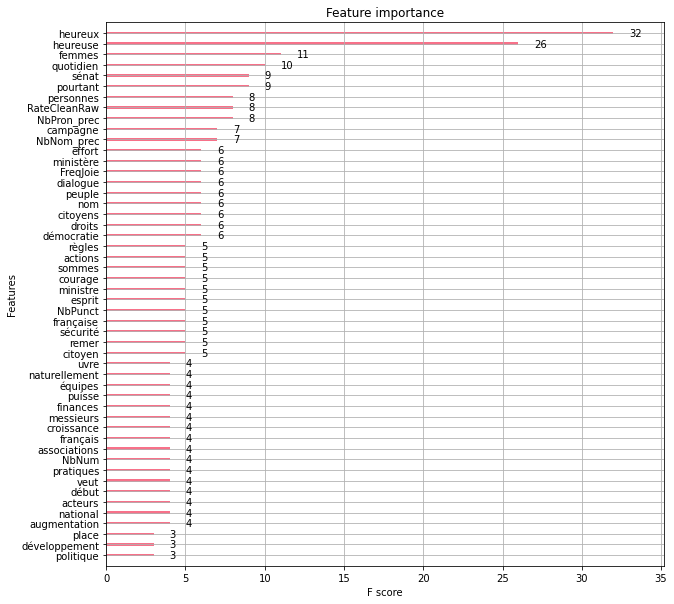

In [0]:
plt.figure(figsize=(10,10))
ax = plot_importance(model,max_num_features=50)
fig = ax.figure
fig.set_size_inches(10, 10)

This time, we are observing the top 50 of our feature importance. Here we can see that some words have a big score. For example, the two most important feature are 'heureux' and 'heureuse'. 

## Part III : CamemBERT model

This section will focus on BERT like model. Notice that this part can be run independently.

### Set up colab GPU and installing main packages

In [0]:
# If you have the documents in your drive already otherwise just drag 'medium_df_desequ.csv' and 'funct.py' in the file section
import os 
os.getcwd()
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# First you should go in 'Edit' -> 'Notebook settings' -> Add device GPU
import tensorflow as tf

# GPU device name.
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

We now can tell torch that one GPU is available 

In [0]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [0]:
!nvidia-smi

Sun Apr 12 08:07:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    32W / 250W |    353MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  



**Please check GPU capacity** that you were given. You might want to reduce the batch size further in the code.  Typically if you were given 8Go memory GPU (Tesla P4) you should set the batch size to 2 not more ! 

We now install the Hugging Face library transformers. You can find all the documentation of hugging face in their Github : https://github.com/huggingface/transformers  

In [0]:
! pip install transformers 

### Loading our corpus and preparing samples 

In [0]:
# We keep the same seed value all along this notebook in order to be able to replicate the results 
seed_val = 42

In [0]:
# Import medium_df_desq in "files" (on the left) this can take some time ! 
import pandas as pd
import numpy as np

# Load the dataset into a pandas dataframe.
df=pd.read_csv('https://raw.githubusercontent.com/cerezamo/NLP_project_MHMP/master/to_put_in_colab/medium_df_deseq.csv',encoding='utf-8')

# Shuffle the date
df=df.sample(frac=1,random_state=seed_val).reset_index(drop=True)

# Some of the speeches are interviews (wrongly classified in the website) we try to delete most of them  
df=df[~df.Texte.str.startswith("Q-")]
df=df[~df.Texte.str.startswith("R-")]
df=df[df.Id!=169898] # FOr some reason a problem on this text occured for preprocessing

# Normalization of the labels [0,1] instead of [1,2] (0 = men, 1 = women)
df.sexe=df.sexe.replace(1,0)
df.sexe=df.sexe.replace(2,1)

# We keep only variables of interest 
df=df[['Id','Titre','Theme','Prenom','Nom','Date','Tags','Texte','sexe']]

# For the cleaning part we will just remove urls, parenthesis and double spacing if any 
import re
def cleaning_stuff(text):
    text = re.sub(r" \(.*?\)", '', text, flags=re.MULTILINE)
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    text = text.replace('(',' ')
    text = text.replace(')',' ')
    text = text.replace('.  ','. ')
    text = text.replace('  ','')
    text=text.replace(" :'","") 
    text = text.strip()
    text = text.replace("\'","'")
    return text 

df['Texte']=df.Texte.apply(cleaning_stuff)
df=df[df.Texte!='']

df = df[~df.Titre.str.startswith('Déclaration conjointe')]
# This is a sample of our dataset
df.head(5)

,Id,Titre,Theme,Prenom,Nom,Date,Tags,Texte,sexe
0,167276,"Déclaration de M. François Fillon, Premier min...",International,François,Fillon,2007-07-13T12:00:00Z,"Relations internationales,Relations bilatérale...","Monsieur le président du Conseil, Mesdames et ...",0
1,177180,"Déclaration de M. François Fillon, Premier min...",NaN,François,Fillon,2009-11-12T12:00:00Z,NaN,"Mesdames et Messieurs les Ministres,Mesdames e...",0
2,173356,"Déclaration de M. François Fillon, Premier min...",Economie,François,Fillon,2008-12-09T12:00:00Z,"Energie - Transports,Transport routier",Monsieur le Conseiller d'Etat de la République...,0
3,170644,"Déclaration de M. Bernard Kouchner, ministre d...",Société,Bernard,Kouchner,2008-05-05T12:00:00Z,"Culture - Médias,Presse",A l'occasion de la 18ème journée international...,0
4,131071,"Déclaration de M. Nicolas Sarkozy, ministre de...",Société,Nicolas,Sarkozy,2002-06-25T12:00:00Z,"Sécurité,Police","Mesdames et Messieurs les commissaires, Au ter...",0


In [0]:
print(df.Texte[200])

Monsieur le président, cher Bruno Favier,Mesdames, messieurs,A l'occasion de la récente Journée mondiale de la maladie de Parkinson, je me retrouve parmi vous aujourd'hui avec satisfaction mais aussi avec gravité.Les premiers Etats généraux des personnes touchées par la maladie de Parkinson ont permis la rédaction d'un Livre Blanc, à l'initiative de l'association France-Parkinson.A vous, son président, cher Bruno Favier - dont j'ai vu avec plaisir le nom figurer dans la promotion de Pâques de la Légion d'honneur -, ainsi qu'à toutes celles et tous ceux qui oeuvrent avec vous au service des malades et de leurs familles, je veux adresser mes plus vifs remerciements.Je connais le remarquable investissement dont vous faites preuve quotidiennement pour soutenir celles et ceux qui souffrent et changer le regard de chacun sur cette maladie mal connue.L'ouvrage que vous venez de me remettre est le fruit d'un important travail de concertation, qui a su fédérer les énergies et auquel ont pris pa

In [0]:
# Import medium_df_desq in "files" (on the left) this can take some time ! 
import pandas as pd
import numpy as np

# Load the dataset into a pandas dataframe.
df_balanced=pd.read_csv('https://raw.githubusercontent.com/cerezamo/NLP_project_MHMP/master/to_put_in_colab/medium_df_eq.csv',encoding='utf-8')

# Shuffle the date

# Some of the speeches are interviews (wrongly classified in the website) we try to delete most of them  
df_balanced=df_balanced[~df_balanced.Texte.str.startswith("Q-")]
df_balanced=df_balanced[~df_balanced.Texte.str.startswith("R-")]
df_balanced=df_balanced[df_balanced.Id!=169898] # FOr some reason a problem on this text occured for preprocessing

# Normalization of the labels [0,1] instead of [1,2] (0 = men, 1 = women)
df_balanced.sexe=df_balanced.sexe.replace(1,0)
df_balanced.sexe=df_balanced.sexe.replace(2,1)

# We keep only variables of interest 
df_balanced=df_balanced[['Id','Titre','Theme','Prenom','Nom','Date','Tags','Texte','sexe']]

# For the cleaning part we will just remove urls, parenthesis and double spacing if any 
import re
def cleaning_stuff(text):
    text = re.sub(r" \(.*?\)", '', text, flags=re.MULTILINE)
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    text = text.replace('(',' ')
    text = text.replace(')',' ')
    text = text.replace('.  ','. ')
    text = text.replace('  ','')
    text=text.replace(" :'","") 
    text = text.strip()
    text = text.replace("\'","'")
    return text 

df_balanced['Texte']=df_balanced.Texte.apply(cleaning_stuff)
df_balanced=df_balanced[df_balanced.Texte!='']

df_balanced = df_balanced[~df_balanced.Titre.str.startswith('Déclaration conjointe')]
# This is a sample of our dataset
df_balanced.head(5)

,Id,Titre,Theme,Prenom,Nom,Date,Tags,Texte,sexe
0,133642,"Déclaration de M. Hervé de Charette, ministre ...",International,Hervé,de Charette,1997-01-13T12:00:00Z,"Relations internationales,Relations bilatérale...","Mesdames et Messieurs, j'ai été très heureux d...",0
1,201364,"Déclaration de M. Michel Sapin, ministre de l'...","Economie,Institutions",Michel,Sapin,2016-11-29T12:00:00Z,"Vie économique,Gestion d'entreprise,Justice - ...","Monsieur le Président,Monsieur le Président de...",0
2,272549,"Déclaration de M. Emmanuel Macron, Président d...",International,Emmanuel,Macron,2019-12-21T12:00:00Z,"Afrique,Côte d'Ivoire","Merci beaucoup Monsieur le Président, cher Ala...",0
3,175752,"Déclaration de M. Guy Hascoët, secrétaire d'Et...",Economie,Guy,Hascoët,2001-05-31T12:00:00Z,"Vie économique,Economie sociale",En ce moment l'Europe est à l'ordre du jour. L...,0
4,186046,Déclaration à la presse de MM. François Hollan...,International,François,Hollande,2012-10-09T12:00:00Z,"Relations internationales,Relations bilatérale...","François HOLLANDE : Mesdames et Messieurs, j'a...",0


**We propose 3 samples to train our model :**


**1.   Unbalanced sample**

We take the raw data without any further treatment.

**2.   Balanced sample**

The second option consists in deleting randomly part of male speeches in order to get a balanced sample. Indeed, in the case of unbalanced sample our model could decide to classify all speakers in the male category which would lead to a 0.75 accuracy in our case study. In order to avoid this we feed the model with the same proportions of male and female speakers. Other kind of treatments exist to deal with unbalanced sample. This one is the simpliest one and we could argue that there is a possibility that the deleted sample contains important information that we therefore miss. However we believe that in our case this is not a big issue. Our unbalanced sample is quite large for both female and male.

**3. Balanced and splitted sample**

The third option is a response to the max length constraint of BERT models. Our text samples are big and contain much more tokens than the 512 limit. In the first two options we decide to feed the model with the 512 first tokens and thus we delete the remaining tokens. In this third option we cut the text into x parts containing approximatively 500 tokens each. All parts of the speech will serve to feed the model. Through this technique we do not loose potential important informations at the end of the text. A lot of other techniques have been employed such as hierarchical transformers (see our latex for reference). We decide to stick to this method in this project but it is an obvious improvment that could be added here. 



In [0]:
def unbalanced_preprocess(df):
  ''' 
  This function just takes our unbalanced dataset and prints relevant informations
  '''

  df_unbalanced=df

  # Reports the number of speeches in the corpus.
  print('Number of text in the unbalanced corpus : {0:.2f}\n'.format(df_unbalanced.shape[0]))

  # Reports the percentage of women in the sample 
  prop = (len(df_unbalanced[df_unbalanced.sexe==1])/len(df_unbalanced))*100
  print('Percentage of women in the unbalanced corpus : {0:.2f}\n'.format(prop))

  return df_unbalanced

In [0]:
df_unbalanced = unbalanced_preprocess(df) 

Number of text in the unbalanced corpus : 4977.00

Percentage of women in the unbalanced corpus : 25.12



In [0]:
def balanced_preprocess(df,seed_val,frac_val):
  ''' 
  This function transforms our unbalanced dataset by deleting male speeches

  Input : 
          df : dataframe
          frac_val : fraction of the sample we want (this is mainly here for testing if you want to train your model with less data)

  Output : 
          df_balanced : A balanced version of our dataset with the same proportion of men and women
  '''

  # Reports the number of speeches in the corpus.
  print('Number of text in this corpus : {0:.2f}\n'.format(df.shape[0]))

  # Reports the percentage of women in the sample 
  prop = (len(df[df.sexe==1])/len(df))*100
  print('Percentage of women in the balanced corpus : {0:.2f}\n'.format(prop))

  return df



In [0]:
df_balanced = balanced_preprocess(df_balanced,seed_val,frac_val=1)

Number of text in this corpus : 4986.00

Percentage of women in the balanced corpus : 50.10



In [0]:
import pandas as pd
def sent_detector_mano(x):
    """
        Détection de phrase à la main.
        Input : document
        Output : liste de phrases
        Problème avec les phrases finissant par : entrainant souvent une liste. 
        De même avec ;. Tentative réalisée
        
    """
    lst =[]
    phrase = []
    i = 0
    for caractere in x: 
        if not (caractere == ' ' and len(phrase) == 0) :
            phrase.append(caractere)
        if caractere in '?!.:;':
            if caractere == ':':
                if x[i+1].isupper() or x[i+2].isupper() or x[i+1] == '-' or x[i+2] == '-':
                    lst.append(''.join(phrase))
                    phrase = []
            if caractere == ';':
                if x[i+1].isupper() or x[i+2].isupper() or x[i+1] == '-' or x[i+2] == '-':
                    lst.append(''.join(phrase))
                    phrase = []
            elif phrase != '.' or phrase != '?' or phrase != '!':
                lst.append(''.join(phrase))
                phrase = []
        i+=1
    return lst
def split_document_to_limit(MAX_TOKENS,df):
  lst= []
  for index,row in df.iterrows():
    identifiant = row.Id
    label = row.sexe
    phrase = []
    for token in row.Texte.split(' '):
      if len(phrase) < MAX_TOKENS:
        phrase.append(token)
      else:
        lst += [(identifiant,label,' '.join(phrase),len(phrase))]
        phrase = []
    if len(phrase)>1:
      lst += [(identifiant,label,' '.join(phrase),len(phrase))]
  return pd.DataFrame(lst,columns=['index_df','sexe','Texte','Length'])
def split_document_to_limit_phrases(MAX_TOKENS,df):
  lst= []
  for index,row in df.iterrows():
    identifiant = row.Id
    label = row.sexe
    phrase = ''
    for phrases in sent_detector_mano(row.Texte):
      if len(phrase.split(' ')) + len(phrases.split(' ')) < MAX_TOKENS:
        phrase+= " " + phrases
      else:
        lst += [(identifiant,label,phrase,len(phrase.split(' ')))]
        phrase = ''
    lst += [(identifiant,label,phrase,len(phrase.split(' ')))]
    phrase = ''
  return pd.DataFrame(lst,columns=['index_df','sexe','Texte','Length'])

In [0]:
def  balanced_splitted(df,seed_val,frac_val,max_tokens):
  
  df=df[df.Texte!='']

  df=split_document_to_limit_phrases(max_tokens,df)
 
  df=df[df.Texte!='']


  # Report the number of speeches in the corpus.
  print('Number of text in this balanced splitted corpus : {:,}\n'.format(df.shape[0]))
  prop = (len(df[df.sexe==1])/len(df))*100
  print('Proportions of women in the balanced splitted corpus : {}\n'.format(prop))

  return df

In [0]:
df_balanced_split = balanced_splitted(df_balanced,seed_val,frac_val=1,max_tokens=450)

Number of text in this balanced splitted corpus : 22,386

Proportions of women in the balanced splitted corpus : 49.906191369606



### Tokenization and preparing to feed CamemBERT

#### Loading the Camembert Tokenizer

In [0]:
# Import Camembert tokenizer
from transformers import CamembertTokenizer
# We choose a right padding side for the moment and we will test for a left padding side on a second stage
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=False,padding_side='right') #left

In [0]:
# Print the original text.
print(' Original: ', df.Texte[0])

# Print the text split into tokens.
print('Tokenized: ', tokenizer.tokenize(df.Texte[0]))

# Print the text mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df.Texte[0])))

 Original:  Monsieur le président du Conseil, Mesdames et Messieurs les ministres, Mesdames et Messieurs les parlementaires, Mesdames et Messieurs les ambassadeurs, Mesdames et Messieurs, Et mes chers compatriotes, Permettez-moi d'abord de vous remercier, cher Romano Prodi, d'être venu ici, au palais Farnèse, pour célébrer avec nous notre Fête nationale. Votre présence aujourd'hui et celle de tant de personnalités italiennes, dans ce magnifique palais de la Renaissance que l'Italie a bien voulu nous confier pour en faire la plus belle de nos ambassades, est la marque de l'amitié forte qui unit nos deux pays et nos deux peuples. Le 14-Juillet est pour nous, Français, un anniversaire que nous sommes particulièrement heureux de célébrer en compagnie de tous les amis de la liberté et de la démocratie. Je veux donc aussi remercier chaleureusement toute la communauté diplomatique réunie ici aujourd'hui. Cher Romano Prodi, j'ai souhaité me rendre à Rome dans les plus brefs délais après ma nom

#### Preparing to feed the model : adding special tokens, attention masks and transform into tensors


Preprocessing steps : 


1.   **Add special tokens [CLS] [SEP]** 

According to the documentation we need to add special tokens to the start and end of the text. Moreover, for camemBERT we should add a space between CLS and the first token. 

2.   **Pad and truncate all texts to a single number**

Pretrained transformers like Camembert only accept input of the same length. Our corpus contains large texts and we have to pad them in order to be able to feed Camembert. We will set the max length to a large number in order to get all information possible in the text. We choose a max length of 500 which is almost the maximum (512) "sentence" length  accepted. We are aware that this choice will impact a lot training speed.

3.   **Construct an attention mask**

Attention masks are just set to 1 when the token have to be analyzed and 0 otherwise (padded tokens). All our attention mask should be 1 with this corpus. 



For sake of simplicity and to avoid errors we will use the function encode_plus of the hugging face library which is really convenient. 



In [0]:
length = 500
batch_size_value = 16
length_train=0.8
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [0]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

texts = df_unbalanced.Texte.values
labels = df_unbalanced.sexe.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
# Apply function to our corpus
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = length,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max 
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])


# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)

# Let's create a 80-20 train / validation dataset 
train_size = int(length_train * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])


print("-------------------------------------------------")
print(" ")
print("How many texts do we have in the train and validation sample ? ")
print(" ")
print('We have {} training texts'.format(train_size))
print('We have {} validation texts'.format(val_size))
print(" ")
print("-------------------------------------------------")

# We set the size of the batch ( usually set around 16 or 32), we will take the lower bound because of the large text length
batch_size = batch_size_value

# We create data loaders for the train and validation dataset. 
train_loader_unbalanced = DataLoader(
            train_set,  # The training samples.
            sampler = RandomSampler(train_set), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

val_loader_unbalanced = DataLoader(
            val_set, # The validation samples.
            sampler = SequentialSampler(val_set), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

print('Data loaders created for train [0] and val [1]')

In [0]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

texts = df_balanced.Texte.values
labels = df_balanced.sexe.values
length = 500
batch_size_value = 16
length_train=0.8
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
# Apply function to our corpus
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = length,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max 
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])


# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)

# Let's create a 80-20 train / validation dataset 
train_size = int(length_train * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])


print("-------------------------------------------------")
print(" ")
print("How many texts do we have in the train and validation sample ? ")
print(" ")
print('We have {} training texts'.format(train_size))
print('We have {} validation texts'.format(val_size))
print(" ")
print("-------------------------------------------------")

# We set the size of the batch ( usually set around 16 or 32), we will take the lower bound because of the large text length
batch_size = batch_size_value

# We create data loaders for the train and validation dataset. 
train_loader_balanced = DataLoader(
            train_set,  # The training samples.
            sampler = RandomSampler(train_set), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

val_loader_balanced = DataLoader(
            val_set, # The validation samples.
            sampler = SequentialSampler(val_set), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

print('Data loaders created for train [0] and val [1]')

In [0]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

texts = df_balanced_split.Texte.values 
labels = df_balanced_split.sexe.values

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
length = 500
batch_size_value = 8
length_train=0.8

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
# Apply function to our corpus
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = length,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max 
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])

# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)

# Let's create a 80-20 train / validation dataset 
train_size = int(length_train * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])


print("-------------------------------------------------")
print(" ")
print("How many texts do we have in the train and validation sample ? ")
print(" ")
print('We have {} training texts'.format(train_size))
print('We have {} validation texts'.format(val_size))
print(" ")
print("-------------------------------------------------")

# We set the size of the batch ( usually set around 16 or 32), we will take the lower bound because of the large text length
batch_size = batch_size_value

# We create data loaders for the train and validation dataset. 
train_loader_balanced_split = DataLoader(
            train_set,  # The training samples.
            sampler = RandomSampler(train_set), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

val_loader_balanced_split = DataLoader(
            val_set, # The validation samples.
            sampler = SequentialSampler(val_set), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

print('Data loaders created for train [0] and val [1]')

### CamemBERT Sequence Classification model tuning


#### Loading the model


We will finally build up our model. We will use the  CamemBERT model for sequence classification which includes a special top layer designed for this task. 

In [0]:
# Importing from transformers
from transformers import CamembertForSequenceClassification, CamembertConfig

In [0]:
# Loading the model
gender_model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base", 
    num_labels = 2, # We have two different labels Women = 1 and Men =0   
    output_attentions = False, 
    output_hidden_states = False, 
)

In [0]:
# We run the model on the colab GPU, we show here the nodes of the models and the several layers
gender_model.cuda()

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

#### Constructing the training and validation loop 


In [0]:
import numpy as np

from sklearn.metrics import f1_score 

def create_report(labels,preds) : 
  pred_flat= np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  F1_score = f1_score(labels_flat,pred_flat,zero_division=1)
  Accuracy = np.sum(pred_flat == labels_flat) / len(labels_flat)
  return F1_score, Accuracy

In [0]:
def train_val_gendermodel(train_loader, val_loader, epochs_val,seed_val,device,lr_value):

  ############################  IMPORT MODEL ################################################
  from transformers import CamembertForSequenceClassification
  gender_model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base", 
    num_labels = 2, # We have two different labels Women = 1 and Men =0   
    output_attentions = False, 
    output_hidden_states = False, )

  model = gender_model
  model.cuda()
  
  ############################## RANDOM SEED ##################################################

  import random
 # Let's put a seed to make this result reproducible 
  seed=seed_val
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  ############################### LEARNING RATE SCHEDULER #######################################

  # https://huggingface.co/transformers/migration.html 
  # https://pytorch.org/docs/stable/optim.html (default values)

  import torch.nn as nn
  import torch.optim as optim
  from transformers import AdamW
  from transformers import get_linear_schedule_with_warmup

  epochs = epochs_val # In order to fine tune our model we will first set the number of epochs to 4.

  #Implements Adam algorithm with weight decay fix.
  opti = AdamW(model.parameters(),
                    lr =lr_value, # learning rate (default = 1e-3)
                    eps = 1e-8 # prevents division by 0 (default = 1e-8)
                  )

  num_training_steps = len(train_loader) * epochs
  # Create a schedule with a learning rate that decreases linearly after linearly increasing during a warmup period (0 here)
  scheduler = get_linear_schedule_with_warmup(opti, 
                                              num_warmup_steps = 0,
                                              num_training_steps = num_training_steps)
  
  
  # We want to evaluate the training phase 
  training_stats = []

  for ep in range(0, epochs):
    print('===========Starting Epoch {} / {} =============='.format(ep+1,epochs))
    print('Training starts')

    ################################### TRAINING ################################

    #Put the model in training mode
    model.train()

    # Set the train loss for the epoch to 0 
    total_train_loss = 0

    for step, batch in enumerate(train_loader):
      # Clear gradients 
      model.zero_grad() # (opti.zerograd ? )

      # Cpy the 3 batch to GPU 
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
      
      #return loss and logits
      loss, logits = model(b_input_ids, 
                          token_type_ids=None, 
                          attention_mask=b_input_mask, 
                          labels=b_labels) 
      
      # Accumulate training loss for all batches 
      total_train_loss += loss.item()

      #Backpropagating the gradients 
      loss.backward()

      # Prevent exploding gradients problem  (forcing the gradients to be small, the parameter updates will not push the parameters too far from their previous values)
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Update parameters 
      opti.step()

      # Update learning rate schedule
      scheduler.step()

    #Calculate the average training loss over all batches  
    avg_train_loss = total_train_loss / len(train_loader)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print('')
    print('Validation starts')

    ###################### VALIDATION #############################

    # Put model in evaluation mode 
    model.eval()

    # Set statistics to 0
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    total_eval_f1=0
    total_roc_auc = 0 

    # Confusion matrix ?
    predictions, true_labels = [], []

    for batch in val_loader:
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
      
      # We don't care about gradients for eval

      with torch.no_grad(): 
        (loss, logits) = model(b_input_ids, 
                                  token_type_ids=None, 
                                  attention_mask=b_input_mask,
                                  labels=b_labels)
      total_eval_loss += loss.item()

        # Move logits and labels to CPU 
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      F1_score, Accuracy = create_report(label_ids,logits)

      # Accumulation accuracy for all batch
      total_eval_accuracy += Accuracy

      # Accumulation f1 for all batch
      total_eval_f1 += F1_score

      
      #Final accuracy on all batch
    avg_val_accuracy = total_eval_accuracy / len(val_loader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      #Final f1 on all batch
    avg_val_f1 = total_eval_f1 / len(val_loader)
    print("  F1_score: {0:.2f}".format(avg_val_f1))

      #Final loss over all batch
    avg_val_loss = total_eval_loss / len(val_loader)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

    training_stats.append(
          {
              'epoch': ep + 1,
              'Train Loss': avg_train_loss,
              'Val Loss': avg_val_loss,
              'Val Accur.': avg_val_accuracy,
              'Val F1' : avg_val_f1,
          }
      )

  print("")
  print("Done !")

  return  training_stats

In [0]:
def report_model_1(results):
  '''
  Input : statistics of the model 
  Output : training and valid loss 
  ''' 
  df_stats = pd.DataFrame(data=results)
  df_stats = df_stats.set_index('epoch')
  print(df_stats)

  import matplotlib.pyplot as plt
  % matplotlib inline
  import seaborn as sns

  # Increase the plot size and font size.
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,6)

  # Plot the learning curve.
  plt.plot(df_stats['Train Loss'], 'b-o', label="Training")
  plt.plot(df_stats['Val Loss'], 'g-o', label="Validation")

  # Label the plot.
  plt.title("Training & Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.xticks([1, 2, 3, 4, 5])

  plt.show()

In [0]:
results_unbalanced = train_val_gendermodel(train_loader=train_loader_unbalanced, val_loader=val_loader_unbalanced, epochs_val=5,seed_val=42,device=device,lr_value=5e-5)

===========Starting Epoch 1 / 5 ==============
Training starts

  Average training loss: 0.42

Validation starts
  Accuracy: 0.86
  F1_score: 0.61
  Validation Loss: 0.35
===========Starting Epoch 2 / 5 ==============
Training starts

  Average training loss: 0.30

Validation starts
  Accuracy: 0.88
  F1_score: 0.70
  Validation Loss: 0.33
===========Starting Epoch 3 / 5 ==============
Training starts

  Average training loss: 0.21

Validation starts
  Accuracy: 0.88
  F1_score: 0.71
  Validation Loss: 0.36
===========Starting Epoch 4 / 5 ==============
Training starts

  Average training loss: 0.14

Validation starts
  Accuracy: 0.88
  F1_score: 0.71
  Validation Loss: 0.46
===========Starting Epoch 5 / 5 ==============
Training starts

  Average training loss: 0.08

Validation starts
  Accuracy: 0.87
  F1_score: 0.69
  Validation Loss: 0.53

Done !


       Train Loss  Val Loss  Val Accur.    Val F1
epoch                                            
1        0.422874  0.351118    0.857143  0.613730
2        0.299098  0.328366    0.882937  0.696951
3        0.214140  0.356034    0.880952  0.706913
4        0.139882  0.462502    0.878968  0.705277
5        0.078685  0.528402    0.866071  0.687949


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


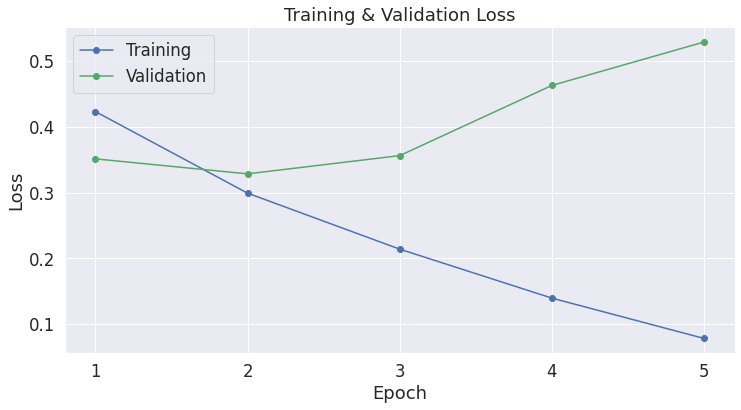

In [0]:
report_model_1(results_unbalanced)

In [0]:
results_balanced = train_val_gendermodel(train_loader=train_loader_balanced, val_loader=val_loader_balanced, epochs_val=5,seed_val=42,device=device,lr_value=5e-5)

===========Starting Epoch 1 / 5 ==============
Training starts

  Average training loss: 0.49

Validation starts
  Accuracy: 0.81
  F1_score: 0.80
  Validation Loss: 0.38
===========Starting Epoch 2 / 5 ==============
Training starts

  Average training loss: 0.32

Validation starts
  Accuracy: 0.84
  F1_score: 0.82
  Validation Loss: 0.40
===========Starting Epoch 3 / 5 ==============
Training starts

  Average training loss: 0.24

Validation starts
  Accuracy: 0.79
  F1_score: 0.75
  Validation Loss: 0.56
===========Starting Epoch 4 / 5 ==============
Training starts

  Average training loss: 0.15

Validation starts
  Accuracy: 0.82
  F1_score: 0.81
  Validation Loss: 0.58
===========Starting Epoch 5 / 5 ==============
Training starts

  Average training loss: 0.08

Validation starts
  Accuracy: 0.81
  F1_score: 0.81
  Validation Loss: 0.67

Done !


       Train Loss  Val Loss  Val Accur.    Val F1
epoch                                            
1        0.485871  0.382030    0.812500  0.798451
2        0.324863  0.404134    0.836310  0.818911
3        0.237608  0.560054    0.791667  0.745788
4        0.146936  0.576387    0.820767  0.811444
5        0.081721  0.673192    0.814815  0.805858


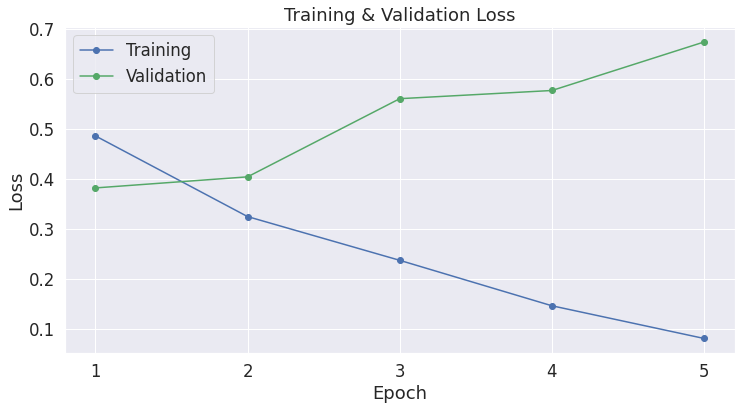

In [0]:
report_model_1(results_balanced)

In [0]:
results_balanced_split = train_val_gendermodel(train_loader=train_loader_balanced_split, val_loader=val_loader_balanced_split, epochs_val=5,seed_val=42,device=device,lr_value=5e-5)

===========Starting Epoch 1 / 5 ==============
Training starts

  Average training loss: 0.49

Validation starts
  Accuracy: 0.81
  F1_score: 0.79
  Validation Loss: 0.42
===========Starting Epoch 2 / 5 ==============
Training starts

  Average training loss: 0.37

Validation starts
  Accuracy: 0.84
  F1_score: 0.83
  Validation Loss: 0.41
===========Starting Epoch 3 / 5 ==============
Training starts

  Average training loss: 0.28

Validation starts
  Accuracy: 0.84
  F1_score: 0.81
  Validation Loss: 0.55
===========Starting Epoch 4 / 5 ==============
Training starts

  Average training loss: 0.18

Validation starts
  Accuracy: 0.84
  F1_score: 0.82
  Validation Loss: 0.65
===========Starting Epoch 5 / 5 ==============
Training starts

  Average training loss: 0.10

Validation starts
  Accuracy: 0.84
  F1_score: 0.83
  Validation Loss: 0.79

Done !


       Train Loss  Val Loss  Val Accur.    Val F1
epoch                                            
1        0.493033  0.418377    0.812500  0.793285
2        0.366962  0.411208    0.840997  0.827072
3        0.275126  0.549749    0.839658  0.813254
4        0.183183  0.647531    0.842783  0.821346
5        0.103236  0.787444    0.843229  0.825468


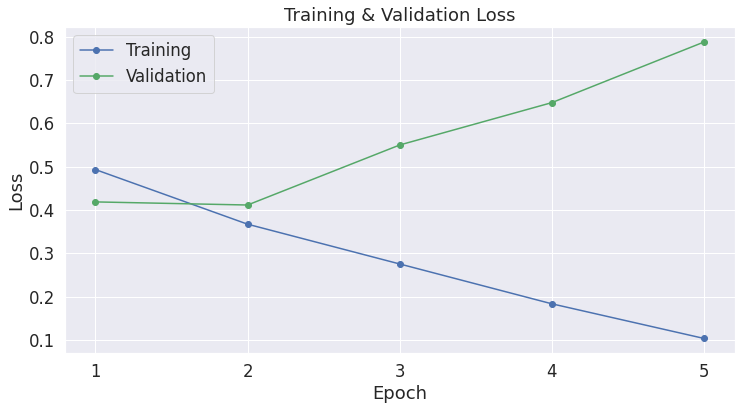

In [0]:
report_model_1(results_balanced_split)

**Overall Performance** : As expected we see that training on a balanced dataset avoid the model to be biased toward men. F1 score is much higher for the balanced sample. 

**Number of epochs** : According to the train and valid loss, 2 to 3 epochs are enough in order to train the model efficiently. More epochs would lead to an overfitting on the training sample. 

**Token limitation** : Let's now compare the method consisting in using only the first 500 token of the texte and the entire text. We have similar results in terms of metrics. We were not expecting such a high result for the second model to begin with but it seems that learning on the first paragraph is enough to be able to classify all them after. 

**Final choice** : Even if the second model is already satisfying, the second might be easier to generalize after and displays higher metrics. We will use the third one in the rest of this section. 

#### Training the optimal model 

In [0]:
df_eval= balanced_splitted(df_balanced,seed_val,frac_val=1,max_tokens=450)

Number of text in this balanced splitted corpus : 22,386

Proportions of women in the balanced splitted corpus : 49.906191369606



In [0]:
# We prepare another sample which will be dedicated to further qualitative analysis

In [0]:
len_dev = round(0.03*len(df_eval))
dev_balanced_split= df_eval[0:len_dev]
df_balanced_split=df_eval[len_dev:len(df_eval)]

# Report the number of speeches in the corpus.
print('Number of text in this balanced splitted corpus : {:,}\n'.format(df_balanced_split.shape[0]))
print('Number of text in the development sample : {:,}\n'.format(dev_balanced_split.shape[0]))

Number of text in this balanced splitted corpus : 21,714

Number of text in the development sample : 672



In [0]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

texts = df_balanced_split.Texte.values 
labels = df_balanced_split.sexe.values

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
length = 500
batch_size_value = 16
length_train=0.9

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
# Apply function to our corpus
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = length,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max 
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])

# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)

# Let's create a 80-20 train / validation dataset 
train_size = int(length_train * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])


print("-------------------------------------------------")
print(" ")
print("How many texts do we have in the train and validation sample ? ")
print(" ")
print('We have {} training texts'.format(train_size))
print('We have {} validation texts'.format(val_size))
print(" ")
print("-------------------------------------------------")

# We set the size of the batch ( usually set around 16 or 32), we will take the lower bound because of the large text length
batch_size = batch_size_value

# We create data loaders for the train and validation dataset. 
train_loader_balanced_split = DataLoader(
            train_set,  # The training samples.
            sampler = RandomSampler(train_set), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

val_loader_balanced_split = DataLoader(
            val_set, # The validation samples.
            sampler = SequentialSampler(val_set), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

print('Data loaders created for train [0] and val [1]')

Let's check for the first text indexes, attention masks and labels
 
Original:   Elle est devenue le premier contributeur au Fonds Africain de Développement. Elle a donc, par la ve
IDs: tensor([    5,   195,    30,  3477,    16,   246, 13152,  2847,    36,  7414,
           21, 23653,     8,  5869,     9,   195,    33,   145,     7,    37,
           13,  4939,     8,    17,    11,  3733,     7,    13, 17460,   462,
          111,  1177,     8, 10700,   108,   843,     8,    89,  1626,    24,
           28, 12844,     8,    17,    11,  6764,    18,    11,   761,  1275,
           36,   499,   376,    37,    13,  1454, 27820,    46,    11,   276,
          731,    20,  3847,  5645,  4343,     9,   139,     8,    44,   299,
            8,   477,     7,    16,   499,     8,    13,  1447,    26, 28295,
            7,    32,   966,    50,   676,  1910,    29,    23,  3334,     7,
         1715,    28, 10845,    95,  1480,    24,    17,    11,  2582,     9])
Attention masks: tensor([1, 1, 1,

In [0]:

############################  IMPORT MODEL ################################################
from transformers import CamembertForSequenceClassification
gender_model = CamembertForSequenceClassification.from_pretrained("camembert-base", 
                                                                  num_labels = 2, 
                                                                  output_attentions = False, 
                                                                  output_hidden_states = False, )

gender_model.cuda()
############################## RANDOM SEED ##################################################

import random
seed=seed_val
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

############################### LEARNING RATE SCHEDULER #######################################

import torch.nn as nn
import torch.optim as optim
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

epochs = 3 

#Implements Adam algorithm with weight decay fix.
opti = AdamW(gender_model.parameters(),
              lr =5e-5, # learning rate (default = 1e-3)
              eps = 1e-8 # prevents division by 0 (default = 1e-8)
            )

num_training_steps = len(train_loader_balanced_split) * epochs

# Create a schedule with a learning rate that decreases linearly after linearly increasing during a warmup period (0 here)
scheduler = get_linear_schedule_with_warmup(opti, 
                                            num_warmup_steps = 0,
                                            num_training_steps = num_training_steps)


for ep in range(0, epochs):
  print('===========Starting Epoch {} / {} =============='.format(ep+1,epochs))
  print('Training starts')

  ################################### TRAINING ################################

  #Put the model in training mode
  gender_model.train()

  # Set the train loss for the epoch to 0 
  total_train_loss = 0

  for step, batch in enumerate(train_loader_balanced_split):
    # Clear gradients 
    gender_model.zero_grad() # 

    # Cpy the 3 batch to GPU 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    #return loss and logits
    loss, logits = gender_model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels) 
    
    # Accumulate training loss for all batches 
    total_train_loss += loss.item()

    #Backpropagating the gradients 
    loss.backward()

    # Prevent exploding gradients problem  (forcing the gradients to be small, the parameter updates will not push the parameters too far from their previous values)
    torch.nn.utils.clip_grad_norm_(gender_model.parameters(), 1.0)

    # Update parameters 
    opti.step()

    # Update learning rate schedule
    scheduler.step()

  #Calculate the average training loss over all batches  
  avg_train_loss = total_train_loss / len(train_loader_balanced_split)
  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))


===========Starting Epoch 1 / 3 ==============
Training starts


KeyboardInterrupt: ignored

In [0]:
torch.save( gender_model, 'gender_model_train.pt')

### Analysis of out optimal model

#### Quantitative analysis of the final model

In [0]:
 def evaluation_loop(model,eval_loader): 
  # Put model in evaluation mode 
  model.eval()
  total_eval_loss,total_pred,total_label,total_logits=[],[],[],[]

  for batch in eval_loader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad(): 
      loss, logits = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
    #total_eval_loss += loss.item()

      # Move logits and labels to CPU 
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      pred= np.argmax(logits, axis=1).flatten()
      labels_flat = label_ids.flatten()

    # Accumulation accuracy for all batch
      total_pred += pred.tolist()

    # Accumulation f1 for all batch
      total_label += labels_flat.tolist()

      # Logits score on positive 
      total_logits += logits.tolist()

  return total_pred,total_label,total_logits

In [0]:
total_pred,total_label,total_logits =evaluation_loop(gender_model,val_loader_balanced_split)

In [0]:
def model_report(pred,label,logits):
    """
        Input :
            pred : model prediction
        Output : 
            Classification_report + Confusion_matrix + ROC_curve
    """
    #from sklearn
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
    logits = [el[1] for el in total_logits]
    pred = [i for i in total_pred]
    label = [i for i in total_label]
    print ("Classification report :")
    print(classification_report(label,pred))
    print ("Accuracy : ",accuracy_score(label,pred))
    cm = confusion_matrix(label,pred)
    ROC = roc_auc_score(label,pred) 
    print ("AUC : ",ROC)
    fpr,tpr,thresholds = roc_curve(label,logits)
    plt.figure(figsize=(12,10))
    plt.subplot(221)
    sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues').set_title('Matrice de confusion')
    plt.subplot(222)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % ROC)
    plt.plot([0,1],[0,1],color='red')
    plt.title('Courbe ROC')
    plt.show()

Classification report :
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1127
           1       0.84      0.85      0.84      1045

    accuracy                           0.85      2172
   macro avg       0.85      0.85      0.85      2172
weighted avg       0.85      0.85      0.85      2172

Accuracy :  0.848987108655617
AUC :  0.8491893199967734


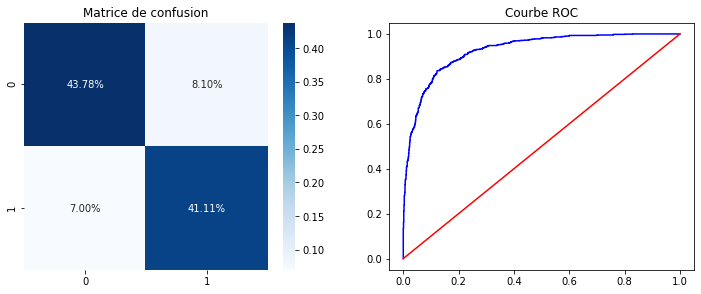

In [0]:
model_report(total_pred,total_label,logits)

We reach good metrics for both accuracy and F1 score. More than 80 % of our predictions are correct. We reach a slightly better result than for XGBoost. In order to increase those metrics we could play on the hyperparameters (loss function into BCE ? learning rate ? scheduler). 


#### Qualitative analysis of the final model

We will use our development set prepared earlier. The qualitative analysis will mainly try to reproduce part 4 of TP 4. 

In [0]:
# We prepare again the development sample for analysis 
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertTokenizer

texts = dev_balanced_split.Texte.values
labels = dev_balanced_split.sexe.values
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=False,padding_side='right')

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]

for text in texts:
  encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 500,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max 
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
  input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
  attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])

# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)
# We create data loaders for the train and validation dataset. 
dev_dataloader = DataLoader(
            dataset,  # The training samples.
            batch_size = 16, # Trains with this batch size.
            shuffle=False
        )

Let's check for the first text indexes, attention masks and labels
 
Original:   Depuis six mois, nous avons défini les leviers qui nous permettront de faire évoluer la situation. 
IDs: tensor([    5,   795,  1638,   250,     7,    63,   296,  7511,    19,  9266,
           10,    31,    63,  6371,     8,    85,  5120,    13,   595,     9,
          121,    11,    73,  8020,   129,  1703,    14,   386,     8,   129,
         5631,    32,   247,  3976,     9,   543,    18,    11,   803,     7,
           19,  4149,    17, 10721,    16,  5631,    68,   678,  3847,  3898,
          263,  1085,    20,  9430,    10,     8,  2815,     8,    17,    11,
         4293,    90,  1848,     8,  8954,    10,     7,     8,  6016,    10,
            7,    65,   200,     8,   218,    20,   389,    29,    19,  4732,
           10,     7,    14,    44,    29,    16,  1346,     8,    13,  1297,
            8,  4732,     9,   148,   210,    13,    93,   337,    24,    19])
Attention masks: tensor([1, 1, 1,

In [0]:
# We make this development sample pass into the evaluation loop 
total_pred,total_labels,total_logits=evaluation_loop(gender_model,dev_dataloader)

In [0]:
def dev_treatment(total_pred,total_labels,total_logits,dev_balanced_split,df):
  ''' 
  This function takes as input the results of the models, compute some statistics and merges the results
  with our first dataset

 Input : 
        model predictions, model labels, model scores, development sample and original data
 Output : 
        merged dataset
  '''
  # Extract the score for label 1 and the maximum score 
  one_score = [el[1] for el in total_logits]
  max_score = np.max(total_logits,axis=1)

  # Put everything inside a dataframe
  results_dev=pd.DataFrame([total_labels,total_pred,one_score,max_score]).transpose()
  results_dev.columns=['returned_labels','model_pred','one_score','max_score']
  results_dev['WF']=pd.DataFrame([results_dev['model_pred']==results_dev['returned_labels']]).transpose()
  results_dev['model_pred'] = results_dev['model_pred'].astype(int)
  results_dev['returned_labels'] = results_dev['returned_labels'].astype(int)

  # Merge back with the text
  frames = [dev_balanced_split[['Texte','sexe','index_df']].reset_index(), results_dev]
  result = pd.concat(frames,axis=1)

  # We merge this dataframe to the information we had at the beginning
  merged_results=result[['index','index_df','Texte','returned_labels','model_pred','one_score','max_score','WF']].merge(df[['Titre','Id','Theme','Prenom','Nom','Date','Tags','sexe']],how='left',left_on='index_df',right_on='Id')

  return merged_results



In [0]:
result =  dev_treatment(total_pred,total_labels,total_logits,dev_balanced_split,df_balanced)

In [0]:
result.head()

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
0,21942,189291,"Depuis six mois, nous avons défini les levier...",1,1,2.520194,2.520194,True,"Déclaration de Mme Aurélie Filippetti, ministr...",189291,Société,Aurélie,Filippetti,2013-10-16T12:00:00Z,"Société - Population,Femme",1
1,10831,181180,"Enfin je crois pouvoir annoncer, en espérant ...",0,0,-2.747468,2.908390,True,"Déclaration de M. Nicolas Sarkozy, Président d...",181180,Société,Nicolas,Sarkozy,2011-02-09T12:00:00Z,"Société - Population,Religion",0
2,19034,171629,"J'ignore si le monde eût été meilleur, dirigé...",1,1,2.632398,2.632398,True,"Déclaration de Mme Catherine Trautmann, minist...",171629,Société,Catherine,Trautmann,1999-03-07T12:00:00Z,"Société - Population,Femme",1
3,16101,204969,"Pour autant, vous le savez, rejoindre l'élite...",1,1,2.525723,2.525723,True,"Déclaration de Mme Agnès Buzyn, ministre des s...",204969,Société,Agnès,Buzyn,2018-01-04T12:00:00Z,"Santé - Protection sociale,Santé publique",1
4,160,160505,"Mes chers amis, permettez-moi, avant d'entrer...",0,0,-2.762880,2.931753,True,"Déclaration de M. François Bayrou, président d...",160505,Institutions,François,Bayrou,2006-01-29T12:00:00Z,"Citoyenneté - Elections,Parti politique",0


In [0]:
#Which texts failed ? 
print('{0:.2f} percent of the development texts were not well classified by our model'.format(result[result.WF==False].WF.count()*100/len(result)))

4.24 percent of the development texts were not well classified by our model


For the next step let's take some texts that were well classified and other that do not. We will take examples for all possible options : badly predicted a woman, badly predicted a man, well predicted a woman and well predicted a man. We also try to take the ones the model was really sure about. 

In [0]:
top_texts_true_m=result[(result.WF==1) & (result.model_pred==0)].nlargest(10,'max_score')
top_texts_true_f=result[(result.WF==1) & (result.model_pred==1)].nlargest(10,'max_score')
top_texts_false_m=result[(result.WF==0) & (result.model_pred==0)].nlargest(10,'max_score')
top_texts_false_f=result[(result.WF==0) & (result.model_pred==1)].nlargest(10,'max_score')

In [0]:
# Texts that were well classified as men 
top_texts_true_m.head(1)

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
425,4129,138933,"Et nous sommes parvenus en décembre 1989, un ...",0,0,-2.776571,2.950638,True,"Discours de M. François Mitterrand, Président ...",138933,International,François,Mitterrand,1990-10-06T12:00:00Z,"Union européenne,Institutions européennes,Unio...",0


In [0]:
# Texts that were well classified as women 
top_texts_true_f.head(1)

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
433,12435,133557,"Avec tous ceux et celles qui nous entourent, ...",1,1,2.726475,2.726475,True,"Déclaration de Mme Marie-George Buffet, secrét...",133557,Institutions,Marie-George,Buffet,2002-11-16T12:00:00Z,"Citoyenneté - Elections,Parti politique",1


In [0]:
# Texts that were wrongly classified as men 
top_texts_false_m.head(1)

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
48,16962,165007,Le « code de conduite » contribuera au renfor...,1,0,-2.708578,2.899973,False,"Déclaration de Mme Michèle Alliot-Marie, minis...",165007,International,Michèle,Alliot-Marie,2007-01-17T12:00:00Z,"Défense,Armement",1


In [0]:
# Texts that were wrongly classified as women
top_texts_false_f.head(1)

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
144,7902,268404,Elle est tout aussi concernée par les inégali...,0,1,2.34333,2.34333,False,"Déclaration de M. Franck Riester, ministre de ...",268404,Société,Franck,Riester,2019-03-13T12:00:00Z,"Société - Population,Femme,Culture - Médias,Pr...",0


We want to dive a bit into the model and see how it makes a choice and why it fails to recognize the gender of the speaker on these sentences . Let's take some of them. We will redo point 4 of TD4.

In [0]:

def split_document_to_limit_phrases(MAX_TOKENS,df):
  lst= []
  for index,row in df.iterrows():
    identifiant = row.Id
    print(identifiant)
    label = row.sexe
    phrase = ''
    for phrases in sent_detector_mano(row.Texte):
      if len(phrase.split(' ')) + len(phrases.split(' ')) < MAX_TOKENS:
        phrase+= " " + phrases
      else:
        lst += [(identifiant,label,phrase,len(phrase.split(' ')))]
        phrase = ''
    lst += [(identifiant,label,phrase,len(phrase.split(' ')))]
    phrase = ''
  return pd.DataFrame(lst,columns=['index_df','sexe','Texte','Length'])

In [0]:
sentence_to_analyse

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
0,16962,165007,Le « code de conduite » contribuera au renfor...,1,0,-2.708578,2.899973,False,"Déclaration de Mme Michèle Alliot-Marie, minis...",165007,International,Michèle,Alliot-Marie,2007-01-17T12:00:00Z,"Défense,Armement",1
1,22202,164830,"Enfin, mon quatrième souhait est la réussite ...",1,0,-2.448090,2.573809,False,"Déclaration de Mme Florence Parly, secrétaire ...",164830,NaN,Florence,Parly,2001-01-16T12:00:00Z,NaN,1
2,13441,185676,"C'est une évolution importante qui obligera, ...",1,0,-2.127576,2.303182,False,"Déclaration de Mme Yamina Benguigui, ministre ...",185676,Société,Yamina,Benguigui,2012-07-23T12:00:00Z,"Culture - Médias,Francophonie",1
3,14751,196666,Il convient de modifier cet état d'esprit. Ai...,1,0,-1.577313,1.667747,False,"Déclaration de Mme Marylise Lebranchu, secréta...",196666,NaN,Marylise,Lebranchu,1999-05-20T12:00:00Z,NaN,1
4,22154,160958,"Donc, là-aussi, d'un commun accord entre les ...",1,0,-1.408362,1.552797,False,"Déclaration de Mme Catherine Colonna, ministre...",160958,International,Catherine,Colonna,2006-03-09T12:00:00Z,"Union européenne,Construction européenne",1
5,16214,272711,"Merci monsieur le Président,Monsieur le Sénat...",1,0,-0.991714,1.093589,False,"Déclaration de Mme Amélie de Montchalin, secré...",272711,International,Amélie,de Montchalin,2020-01-08T12:00:00Z,"Asie,Iran",1
6,16490,205471,"Bonjour à tous,Tout d'abord je tiens à remerc...",1,0,-0.693555,0.754806,False,"Déclaration de Mme Delphine Gény-Stephann, sec...",205471,Institutions,Delphine,Geny-Stephann,2018-04-05T12:00:00Z,"Justice - Droits fondamentaux,Propriété intell...",1
7,19629,199105,"Monsieur le Président,Madame la Présidente de...",1,0,-0.671267,0.668331,False,"Déclaration de Mme Ségolène Royal, ministre de...",199105,Société,Ségolène,Royal,2016-05-17T12:00:00Z,"Environnement,Climat",1
8,15307,162621,Gardons longtemps en mémoire l'affaire qui po...,1,0,-0.305766,0.416392,False,"Déclaration de Mme Michèle Alliot-Marie, minis...",162621,Institutions,Michèle,Alliot-Marie,2006-07-12T12:00:00Z,"Justice - Droits fondamentaux,Justice",1
9,17281,166122,II. C'est dans le même esprit que nous examin...,1,0,-0.187719,0.264935,False,"Déclaration de Mme Michèle Alliot-Marie, minis...",166122,International,Michèle,Alliot-Marie,2007-03-30T12:00:00Z,"Défense,Politique de la défense",1


In [0]:
# We split those texts into pieces of 50 tokens
sentence_to_analyse = pd.concat([top_texts_false_m,top_texts_true_m,top_texts_true_f,top_texts_true_f]).reset_index(drop=True)

In [0]:
sentence_to_analyse=sentence_to_analyse[sentence_to_analyse.index_df != 160958]
sentence_to_analyse=split_document_to_limit(60,sentence_to_analyse)
sentence_to_analyse=sentence_to_analyse[sentence_to_analyse.Texte!='']

In [0]:
# Sentences we will analyze
sentence_to_analyse.Texte

0       Le « code de conduite » contribuera au renfor...
1      le réveil des égoïsmes nationaux. Nous ne devo...
2      crédible doit être poursuivi. Pour l'équipemen...
3      Barracuda, le missile de croisière naval, Feli...
4      progressé ces derniers mois avec nos partenair...
                             ...                        
279    ? Je transmettrai vos compliments, sans faire ...
280    et sera disponible à la rentrée dans les outre...
281    s'en sont emparés et se sont familiarisés avec...
282    mais, compte tenu de l'usage qui est fait de l...
283    la justice administrative. Bien entendu, ce tr...
Name: Texte, Length: 284, dtype: object

In [0]:
# We prepare the sentences
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertTokenizer

texts = sentence_to_analyse.Texte.values
labels = sentence_to_analyse.sexe.values
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=False,padding_side='right')

input_ids = []
attention_masks = []
num_truncated_tokens =[]

for text in texts:
  encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 60,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max 
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
  
  input_ids.append(encoded_dict['input_ids'])
  attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[1][0:100])
print('IDs:', input_ids[1][0:100])
print('Attention masks:', attention_masks[1][0:100])
print('labels',labels[1])

dataset = TensorDataset(input_ids, attention_masks, labels)

dev_dataloader = DataLoader(
            dataset,  # The training samples.
            batch_size = 1, # Trains with this batch size.
            shuffle=False
        )

Let's check for the first text indexes, attention masks and labels
 
Original:  le réveil des égoïsmes nationaux. Nous ne devons pas tomber dans la facilité du protectionnisme et n
IDs: tensor([    5,    16,  8419,    20,    21, 29706,    10,  6310,     9,   170,
           45,  4092,    34,  2173,    29,    13,  4372,    25,   872,  7742,
           14,    45, 30575,   631,  2081, 25050,     7,    22,   184,    47,
          222,   166,  1626,     9,  8596,    28,  1703,  1467,  4141,    14,
         1439,  5309,    28,  6946,    15,   166, 22089,    32,    17,    11,
         2128,     8,    17,    11,  1354,    14,     8,    13,   184,     6])
Attention masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
labels tensor(1)


In [0]:
total_pred,total_labels,total_logits =evaluation_loop(gender_model,dev_dataloader)

In [0]:
result_sentence =  dev_treatment(total_pred,total_labels,total_logits,sentence_to_analyse,df_balanced)

In [0]:
result_sentence.head()

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
0,0,165007,Le « code de conduite » contribuera au renfor...,1,1,1.121554,1.121554,True,"Déclaration de Mme Michèle Alliot-Marie, minis...",165007,International,Michèle,Alliot-Marie,2007-01-17T12:00:00Z,"Défense,Armement",1
1,1,165007,le réveil des égoïsmes nationaux. Nous ne devo...,1,1,1.412667,1.412667,True,"Déclaration de Mme Michèle Alliot-Marie, minis...",165007,International,Michèle,Alliot-Marie,2007-01-17T12:00:00Z,"Défense,Armement",1
2,2,165007,crédible doit être poursuivi. Pour l'équipemen...,1,0,-1.591321,1.727327,False,"Déclaration de Mme Michèle Alliot-Marie, minis...",165007,International,Michèle,Alliot-Marie,2007-01-17T12:00:00Z,"Défense,Armement",1
3,3,165007,"Barracuda, le missile de croisière naval, Feli...",1,0,-0.768244,0.885135,False,"Déclaration de Mme Michèle Alliot-Marie, minis...",165007,International,Michèle,Alliot-Marie,2007-01-17T12:00:00Z,"Défense,Armement",1
4,4,165007,progressé ces derniers mois avec nos partenair...,1,0,-2.161506,2.359916,False,"Déclaration de Mme Michèle Alliot-Marie, minis...",165007,International,Michèle,Alliot-Marie,2007-01-17T12:00:00Z,"Défense,Armement",1


In [0]:
#How many sentences were not well classified ? 
print('{0:.2f} percent of the development texts were not well classified by our model'.format(result[result.WF==False].WF.count()*100/len(result)))

4.24 percent of the development texts were not well classified by our model


We redo the same exercice as before. Here with our pieces of text

In [0]:
top_sentence_true_m=result_sentence[(result_sentence.WF==1) & (result_sentence.model_pred==0)].nlargest(1,'max_score')
top_sentence_true_f=result_sentence[(result_sentence.WF==1) & (result_sentence.model_pred==1)].nlargest(1,'max_score')
top_sentence_false_m=result_sentence[(result_sentence.WF==0) & (result_sentence.model_pred==0)].nlargest(1,'max_score')
top_sentence_false_f=result_sentence[(result_sentence.WF==0) & (result_sentence.model_pred==1)].nlargest(1,'max_score')

In [0]:
top_sentence_false_m

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
45,45,199105,la place à la reconnaissance que ce dernier ne...,1,0,-2.530934,2.671229,False,"Déclaration de Mme Ségolène Royal, ministre de...",199105,Société,Ségolène,Royal,2016-05-17T12:00:00Z,"Environnement,Climat",1


In [0]:
top_sentence_false_f

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
125,125,127882,et sur une identité culturelle.,0,1,0.562271,0.562271,False,"Déclaration de M. Lionel Jospin, Premier minis...",127882,Institutions,Lionel,Jospin,2002-03-21T12:00:00Z,"Citoyenneté - Elections,Personnalité politique",0


In [0]:
top_sentence_true_m

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
111,111,133642,"Mesdames et Messieurs, j'ai été très heureux ...",0,0,-2.753851,2.920542,True,"Déclaration de M. Hervé de Charette, ministre ...",133642,International,Hervé,de Charette,1997-01-13T12:00:00Z,"Relations internationales,Relations bilatérale...",0


In [0]:
top_sentence_true_f

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
204,204,195250,"? Je transmettrai vos compliments, sans faire ...",1,1,2.664879,2.664879,True,"Déclaration de M. Christiane Taubira, garde de...",195250,Institutions,Christiane,Taubira,2015-06-18T12:00:00Z,"Justice - Droits fondamentaux,Organisation jud...",1


In [0]:
words_to_analyse = pd.concat([top_sentence_false_m,top_sentence_true_m,top_sentence_false_f,top_sentence_true_f]).reset_index(drop=True)
words_to_analyse.insert(2, "type_fail", ['false_m','true_m','false_f','true_f'], True) 

In [0]:
# We split those sentences into words
lst= []
for index,row in words_to_analyse.iterrows():
  identifiant = row.index_df
  label = row.sexe
  type_fail = row.type_fail
  phrase = []
  for token in row.Texte.split(' '):
      lst += [(identifiant,label,token,type_fail)]

In [0]:
words_to_analyse=pd.DataFrame(lst,columns=['index_df','sexe','Texte','type_fail'])
words_to_analyse=words_to_analyse[words_to_analyse.Texte!='']

In [0]:
words_to_analyse=words_to_analyse[words_to_analyse.Texte!='']
words_to_analyse.head()

,index_df,sexe,Texte,type_fail
0,199105,1,la,false_m
1,199105,1,place,false_m
2,199105,1,à,false_m
3,199105,1,la,false_m
4,199105,1,reconnaissance,false_m


In [0]:
# We prepare again the development sample for analysis 

from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertTokenizer

texts = words_to_analyse.Texte.values
labels = words_to_analyse.sexe.values
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=False,padding_side='right')

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]

for text in texts:
  encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 5,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max 
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
  input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
  attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])

# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)
# We create data loaders for the train and validation dataset. 
dev_dataloader = DataLoader(
            dataset,  # The training samples.
            batch_size = 1, # Trains with this batch size.
            shuffle=False
        )

Let's check for the first text indexes, attention masks and labels
 
Original:  la
IDs: tensor([ 5, 13,  6,  1,  1])
Attention masks: tensor([1, 1, 1, 0, 0])
labels tensor(1)


In [0]:
total_pred,total_labels,total_logits =evaluation_loop(gender_model,dev_dataloader)

In [0]:
result_words =  dev_treatment(total_pred,total_labels,total_logits,words_to_analyse,df_balanced)

In [0]:
type_fail = ['top_sentence_false_m','top_sentence_true_m','top_sentence_false_f','top_sentence_true_f']
identifier = list(result_words.Id.unique())

In [0]:
scores = [i for i in result_words[result_words.index_df==identifier[0]].one_score]
df_plot_false_m=pd.DataFrame(scores).transpose()
df_plot_false_m.columns=list(result_words[result_words.index_df==identifier[0]].Texte)
scores = [i for i in result_words[result_words.index_df==identifier[1]].one_score]
df_plot_true_m=pd.DataFrame(scores).transpose()
df_plot_true_m.columns=list(result_words[result_words.index_df==identifier[1]].Texte)
scores = [i for i in result_words[result_words.index_df==identifier[2]].one_score]
df_plot_false_f=pd.DataFrame(scores).transpose()
df_plot_false_f.columns=list(result_words[result_words.index_df==identifier[2]].Texte)
scores = [i for i in result_words[result_words.index_df==identifier[3]].one_score]
df_plot_true_f=pd.DataFrame(scores).transpose()
df_plot_true_f.columns=list(result_words[result_words.index_df==identifier[3]].Texte)


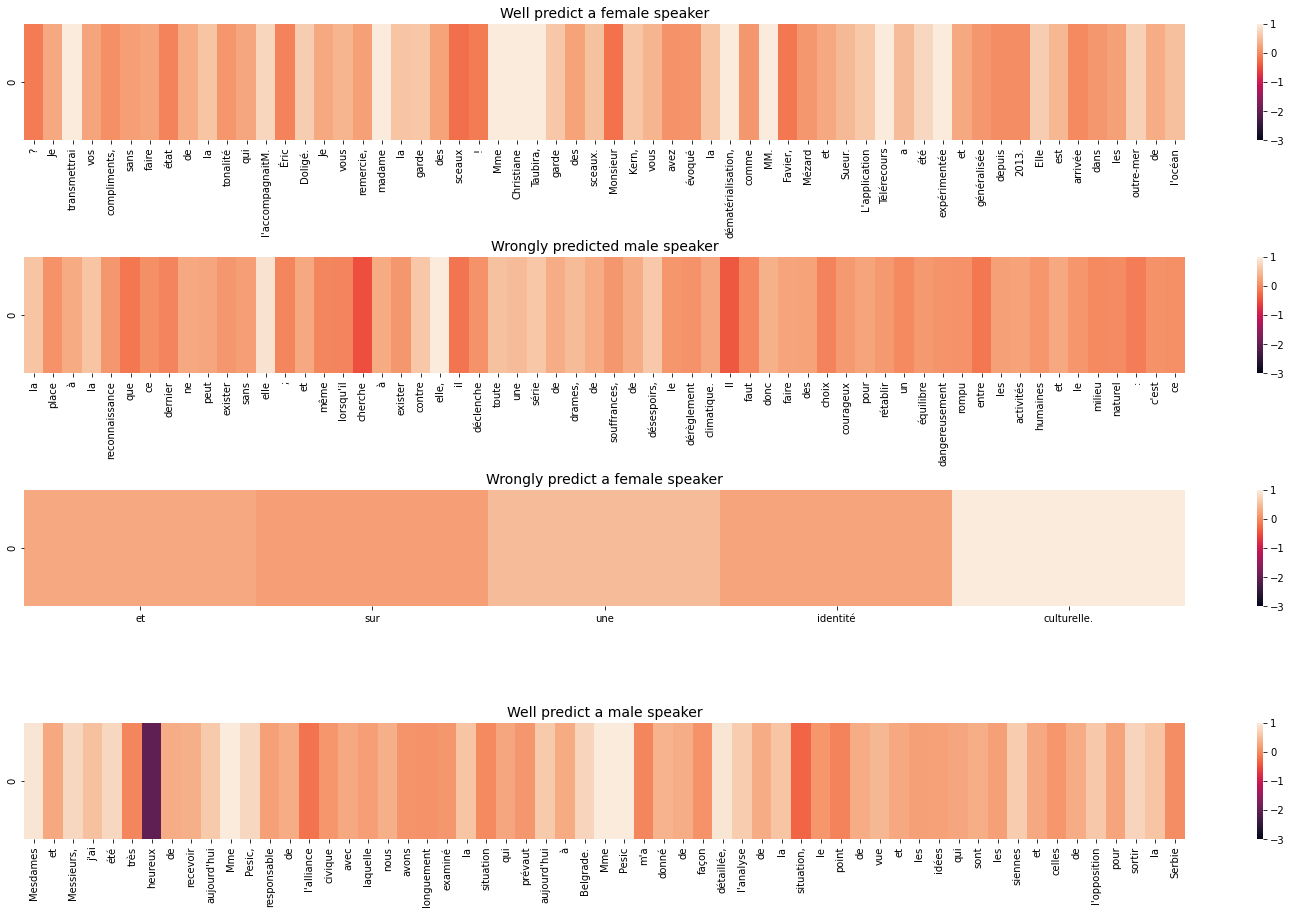

In [0]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(26,15))

#  heatmap - female subplot
fig.add_subplot(411)
plt.title('Well predict a female speaker', fontsize=14)
sns.heatmap(df_plot_true_f, annot=False, fmt='.2f',vmin=-3,vmax=1)

#  heatmap - male subplot
fig.add_subplot(412)
plt.title('Wrongly predicted male speaker', fontsize=14)
sns.heatmap(df_plot_false_m, annot=False, fmt='.2f',vmin=-3,vmax=1 )

#  heatmap - male subplot
fig.add_subplot(413)
plt.title('Wrongly predict a female speaker', fontsize=14)
sns.heatmap(df_plot_false_f, annot=False, fmt='.2f',vmin=-3,vmax=1 )

#  heatmap - male subplot
fig.add_subplot(414)
plt.title('Well predict a male speaker', fontsize=14)
sns.heatmap(df_plot_true_m, annot=False, fmt='.2f',vmin=-3,vmax=1 )

plt.subplots_adjust(hspace=1)
#fig.tight_layout(pad=3.0)
plt.show()


References 

https://bib.irb.hr/datoteka/861053.Gender_differences_in_the_personal_pronouns_usage_of_the_corpus_of_congressional_speeches.pdf

https://www.researchgate.net/publication/253291274_Gender_Differences_in_Language_Use_An_Analysis_of_14000_Text_Samples/link/571e3c1b08aeaced7889ddce/download
https://buhrmann.github.io/tfidf-analysis.html
https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4